<strong>CM3070 Final Project <br>
Student ID: 210486014 <br>
Name: Amos Kam Hong Yoke <br>
Title: Content-Based approach on Fake News Detection using Machine Learning <br> </strong>

### Import necessary libraries

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install nltk

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt

# Feature Extraction libraries
from sklearn.model_selection import train_test_split
# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
# N-Grams
from sklearn.feature_extraction.text import CountVectorizer
# Word2Vec
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Model Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Evaluation Metri
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Data Preparation Stage

### Data Exploration

#### Read the data from dataset (news.csv)

In [5]:
# Run this block to use the local copy and skip the pre-processing stage.
# Else skip this cell.
baseline_df=pd.read_csv('baseline_news.csv')
clean_df=pd.read_csv('clean_news.csv')
clean_df = clean_df.astype(str)

In [4]:
#Code and news.csv source from https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

#DataFlair - Read the data
df=pd.read_csv('news.csv')

#DataFlair - Get shape and head
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [41]:
df.shape

(6335, 4)

According to the dataset source the first coloumn is some sort of identifier for the news. It is irrelevant in our use case hence we will drop this column in the data cleaning part later.

In [42]:
#DataFlair - Get the labels
labels=df.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [43]:
#Show the number of Real News and Fake News in dataset
labels.value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

There are a total number of 3171 rows of data labeled as REAL and 3164 rows of data labeled as FAKE

In [44]:
df.isna().sum()  

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Dataset seems to have no missing values and is generally clean except for the first column containing the news identifier which is irrelevant to our use case.

#### Data cleaning

As mentioned earlier, we will be dropping the first column as well as "title" column as I deemed that when comparing to the "text" column, "title" may have little to no impact, removing it will reduce file size and training time.

In [45]:
df.drop(columns=df.columns[[0,1]], axis=1,  inplace=True)
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [46]:
df.shape

(6335, 2)

We check the shape and first 5 rows of the dataset to ensure we only drop the column.

Now that our baseline dataset is prepared and ready for the further processing, we will save a local copy so we don't have to run these cleaning process everytime.

In [47]:
df.to_csv("baseline_news.csv", sep=',', index=False, encoding='utf-8')

Verify the local copy is same as the baseline dataset

In [48]:
baseline_df = pd.read_csv('baseline_news.csv')
baseline_df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [49]:
baseline_df.shape

(6335, 2)

We have verified that the local baseline dataset is the same as our baseline dataset.

#### Stemming and Stop words removal

We will proceed to create a cleaned dataset that is baseline dataset that incorporates stemming and stop words removal for improved analysis.

In [50]:
clean_df = baseline_df.copy()

stop_words = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.snowball.SnowballStemmer("english")

for i in range(len(clean_df)):
    # Extract the text from every row
    string = clean_df['text'].at[i]
    # Tokenise the string
    tokens = nltk.tokenize.word_tokenize(string)
    # Remove stopwords from the tokens
    tokens = [word for word in tokens if word not in stop_words]
    # Apply stemming to the tokens answer
    tokens = [stemmer.stem(word) for word in tokens]
    # Replace original text with cleaned text
    clean_df.at[i, 'text'] = ' '.join(tokens)
    
clean_df.head()

,text,label
0,"daniel greenfield , shillman journal fellow fr...",FAKE
1,googl pinterest digg linkedin reddit stumbleup...,FAKE
2,u.s. secretari state john f. kerri said monday...,REAL
3,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",FAKE
4,it 's primari day new york front-runn hillari ...,REAL


Check for any NA values

In [51]:
clean_df.isna().sum()  

text     0
label    0
dtype: int64

Now that our cleaned dataset is prepared and ready for the further processing, we will also save this locally to save time.

In [52]:
clean_df.to_csv("clean_news.csv", sep=',', index=False, encoding='utf-8')

As we did for the baseline dataset, we will verify the local copy with the cleaned dataset

In [53]:
clean_df=pd.read_csv('clean_news.csv')
clean_df = clean_df.astype(str)
clean_df.head()

,text,label
0,"daniel greenfield , shillman journal fellow fr...",FAKE
1,googl pinterest digg linkedin reddit stumbleup...,FAKE
2,u.s. secretari state john f. kerri said monday...,REAL
3,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",FAKE
4,it 's primari day new york front-runn hillari ...,REAL


In [54]:
clean_df.shape

(6335, 2)

In [55]:
clean_df.label.value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

Perfect, the local cleaned dataset is the same as our cleaned dataset.

As mentioned in the report, the purpose of this is to compare the results to see if incorporating stemming and stop words removal will impact the accuracy of our models.

# Feature Extraction Stage

In this feature prototype 2 we will be implementing all 3 feature extraction methods mentioned in our report, TF-IDF, N-Gram and Word2Vec.

#### TF-IDF Feature Extraction

Dataset will be splitted into training set and test set at the ratio of 8:2, random state will be set at 7 to ensure same dataset split across every training to eliminate variables.

I will be creating helper functions for each feature extraction methods to reduce code repetition and improve readability.

In [6]:
# Helper functions that extract TF-IDF feature and return its vectorized form.
def featureExtract_TFIDF(data):
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=7)

    #Initialize the vectorizer (Currently without hyperparameter)
    vectorizer = TfidfVectorizer()

    # Transform the training and testing text data into TFIDF features
    tfidf_train = vectorizer.fit_transform(x_train) 
    tfidf_test = vectorizer.transform(x_test)
    
    return tfidf_train, tfidf_test, y_train, y_test

#### N-Grams

In [7]:
# Helper functions that extract N-Gram feature and return its vectorized form.
def featureExtract_Ngram(data):
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=7)

    # Initialize the CountVectorizer using bigram (ngram_range=2)
    vectorizer = CountVectorizer(ngram_range=(1, 2))

    # Transform the training and testing text data into N-Gram features
    ngram_train = vectorizer.fit_transform(x_train) 
    ngram_test = vectorizer.transform(x_test) 
    
    return ngram_train, ngram_test, y_train, y_test

#### Word2Vec

In [15]:
# Helper function to vectorize each word in the doc.
def document_vector(doc, model):
    # Get the word vectors for all words in the document
    vectors = [model.wv[word] for word in doc if word in model.wv]
    # Return the mean of the word vectors
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Helper function to call document_vector on each row of data.
def document_vectorizer(docs, word2vec_model, clip_threshold=None):
    vectors = np.array([document_vector(doc, word2vec_model) for doc in docs])
    if clip_threshold is not None:
        vectors = np.clip(vectors, 0, None)
    return vectors
    
# Helper functions that extract Word2Vec feature and return its vectorized form.
# It relies on two additional helper functions document_vectorizer and document_vector which helps to vectorize the dataset at the word level.
def featureExtract_W2V(data, clip_threshold=None):
    #  Tokenize every row into sentences.
    sentences = data['text'].apply(lambda x: x.split())
    
    # Train the Word2Vec Model based on the sentences
    word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1)

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=7)
    
    # Transform training and test sets into Word2Vector features.
    x_train_vectors = document_vectorizer(x_train, word2vec_model, clip_threshold=0)
    x_test_vectors = document_vectorizer(x_test, word2vec_model, clip_threshold=0)

    return x_train_vectors, x_test_vectors, y_train, y_test
    

# Model Training Stage and Evaluation Stage

Model Training Stage and Evaluation Stage has been categorized into a single stage due to the pipeline that we will be developing below.

In [95]:
# Helper Functions to extract the various evaluation metrics into a dictionary.
# All forms of matrix should be extracted here as they are unavailable once it exits the pipeline

def scoresToDict(y_test, y_pred, y_pred_probaility, model):
    fpr , tpr, _ =  roc_curve(y_test, y_pred_probaility, pos_label="REAL")
    scores = {
    'Model': model,
    'Accuracy': round(accuracy_score(y_test,y_pred)*100,2),
    'Precision': round(precision_score(y_test, y_pred, pos_label='REAL')*100,2),
    'Recall' : round(recall_score(y_test, y_pred, pos_label='REAL')*100,2),
    'F1' : round(f1_score(y_test, y_pred, pos_label='REAL')*100,2),
    'ROC' : round(roc_auc_score(y_test, y_pred_probaility)*100,2),
    'CM' : confusion_matrix(y_test, y_pred),
    'Curve' : (fpr , tpr),
    }
    return scores

In [1]:
# Custom pipeline that encapsulates the process from feature extraction to 
# model training and finally to extraction of various evaluation metrics.
def pipeline(data, feature, m):
    # Base on the input, apply the appropriate feature extraction methods and data set splits
    x_train = x_test = y_train = y_test = None
    if feature == "TFIDF":
        x_train, x_test, y_train, y_test = featureExtract_TFIDF(data)
    elif feature == "N-Gram":
        x_train, x_test, y_train, y_test = featureExtract_Ngram(data)   
    elif feature == "Word2Vec":
        # Clip threshold is set to 0 only for MultinomialNB as it does not take negative values
        clip_threshold = 0 if m == 'Naive Bayes' else None
        x_train, x_test, y_train, y_test = featureExtract_W2V(data, clip_threshold=clip_threshold)   
    elif feature == None:
        print("Error, feature extraction method not found!")
    
    # Initialise the model based on input
    model = None
    if m =='Naive Bayes':
        model = MultinomialNB()
    elif m == 'Decision Tree':
        model = DecisionTreeClassifier()
    elif m == 'Random Forest':
        model = RandomForestClassifier()
    elif m == 'Logistic Regression':
        model = LogisticRegression(max_iter=1000)
    elif m == 'SVM':
        model = svm.SVC(probability=True)
    elif model == None:
        print("Error, model not found!")

    # Fit the data set to the model.
    model.fit(x_train, y_train)
    # Predict the results.
    y_pred = model.predict(x_test)
    # Predict the probability for ROC plotting.
    y_pred_probability = model.predict_proba(x_test)[:, 1]
    
    # Save the various evaluation metrics to a dictionary.
    scoresDict = scoresToDict(y_test, y_pred, y_pred_probability, model=m)
    
    return scoresDict

By having this custom data pipeline, we simple have to indicate the data and the model and the pipeline will return the result in the form of a dictionary.

#### Executing Model Training and Evaluation Metric extraction

In [97]:
# As the pipeline returns the result using TFIDF on a single model, I have created a function getScores that compiles the results from all models
def getScores(data, feature):
    models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM']
    results_list  = []
    for model in models:
        score = pipeline(data, feature, model)
        results_list.append(score)
        
    results = {}
    for key in results_list[0].keys():
        results[key] = [result[key] for result in results_list]
    
    return results

#### Results for Models trained on Baseline dataset (TFIDF)

In [98]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins
base_results_TFIDF = getScores(baseline_df, "TFIDF")
base_results_TFIDF = pd.DataFrame(base_results_TFIDF)
# Print the data frame in string form without the confusion matrix
print("Results of models trained on Baseline Dataset and TF-IDF\n")
print(base_results_TFIDF.drop(base_results_TFIDF.columns[-2:], axis=1, inplace=False).to_string(index=False))

Results of models trained on Baseline Dataset and TF-IDF

              Model  Accuracy  Precision  Recall    F1   ROC
        Naive Bayes     81.61      73.19   99.36 84.29 96.89
      Decision Tree     80.90      79.82   82.35 81.06 80.91
      Random Forest     88.71      89.84   87.12 88.46 95.61
Logistic Regression     91.55      92.79   89.98 91.36 97.31
                SVM     92.58      94.07   90.78 92.39 98.28


In [99]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins
base_results_ngram = getScores(baseline_df, "N-Gram")
base_results_ngram = pd.DataFrame(base_results_ngram)
# Print the data frame in string form without the confusion matrix
print("Results of models trained on Baseline Dataset and N-Gram\n")
print(base_results_ngram.drop(base_results_ngram.columns[-2:], axis=1, inplace=False).to_string(index=False))

Results of models trained on Baseline Dataset and N-Gram

              Model  Accuracy  Precision  Recall    F1   ROC
        Naive Bayes     89.58      83.54   98.41 90.36 93.36
      Decision Tree     81.61      81.33   81.72 81.52 81.61
      Random Forest     87.53      88.29   86.33 87.30 94.24
Logistic Regression     92.11      92.87   91.10 91.97 97.34
                SVM     85.32      93.18   75.99 83.71 93.75


In [100]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins
base_results_w2v = getScores(baseline_df, "Word2Vec")
base_results_w2v = pd.DataFrame(base_results_w2v)
# Print the data frame in string form without the confusion matrix
print("Results of models trained on Baseline Dataset and Word2Vec\n")
print(base_results_w2v.drop(base_results_w2v.columns[-2:], axis=1, inplace=False).to_string(index=False))

Results of models trained on Baseline Dataset and Word2Vec

              Model  Accuracy  Precision  Recall    F1   ROC
        Naive Bayes     59.83      57.04   77.27 65.63 63.96
      Decision Tree     67.09      67.15   65.98 66.56 67.08
      Random Forest     75.14      75.91   73.13 74.49 84.08
Logistic Regression     66.54      65.14   70.11 67.53 72.86
                SVM     68.98      65.57   79.01 71.67 76.19


#### Results for Models trained on Clean dataset (TFIDF)

In [101]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins
clean_results_TFIDF = getScores(clean_df, "TFIDF")
clean_results_TFIDF = pd.DataFrame(clean_results_TFIDF)
# Print the data frame in string form without the confusion matrix
print("Results of models trained on Clean Dataset and TF-IDF\n")
print(clean_results_TFIDF.drop(clean_results_TFIDF.columns[-2:], axis=1, inplace=False).to_string(index=False))

Results of models trained on Clean Dataset and TF-IDF

              Model  Accuracy  Precision  Recall    F1   ROC
        Naive Bayes     84.61      77.12   98.09 86.35 96.91
      Decision Tree     79.40      79.87   78.22 79.04 79.39
      Random Forest     89.50      90.26   88.39 89.32 96.52
Logistic Regression     92.11      93.43   90.46 91.92 97.72
                SVM     92.98      94.12   91.57 92.83 98.36


In [102]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins
clean_results_ngram = getScores(clean_df, "N-Gram")
clean_results_ngram = pd.DataFrame(clean_results_ngram)
# Print the data frame in string form without the confusion matrix
print("Results of models trained on Clean Dataset and N-Gram\n")
print(clean_results_ngram.drop(clean_results_ngram.columns[-2:], axis=1, inplace=False).to_string(index=False))

Results of models trained on Clean Dataset and N-Gram

              Model  Accuracy  Precision  Recall    F1   ROC
        Naive Bayes     90.45      84.70   98.57 91.11 93.90
      Decision Tree     83.27      83.68   82.35 83.01 83.26
      Random Forest     88.32      89.88   86.17 87.99 95.20
Logistic Regression     92.50      93.06   91.73 92.39 97.16
                SVM     88.48      94.31   81.72 87.56 95.83


In [103]:
# Do note that since we are running multiple pipelines in one function. Do expect some delays especially on remote, virtual or older devices.
# Estimated wait time to be 5-10 mins
clean_results_w2v = getScores(clean_df, "Word2Vec")
clean_results_w2v = pd.DataFrame(clean_results_w2v)
# Print the data frame in string form without the confusion matrix and roc curve calulations
print("Results of models trained on Clean Dataset and Word2Vec\n")
print(clean_results_w2v.drop(clean_results_w2v.columns[-2:], axis=1, inplace=False).to_string(index=False))

Results of models trained on Clean Dataset and Word2Vec

              Model  Accuracy  Precision  Recall    F1   ROC
        Naive Bayes     59.35      55.50   91.41 69.07 73.21
      Decision Tree     69.46      68.91   70.11 69.50 69.46
      Random Forest     77.11      80.65   70.91 75.47 85.53
Logistic Regression     73.95      77.53   66.93 71.84 81.95
                SVM     71.59      79.18   58.03 66.97 78.91


## Visualizing the performance of each model using bar graph

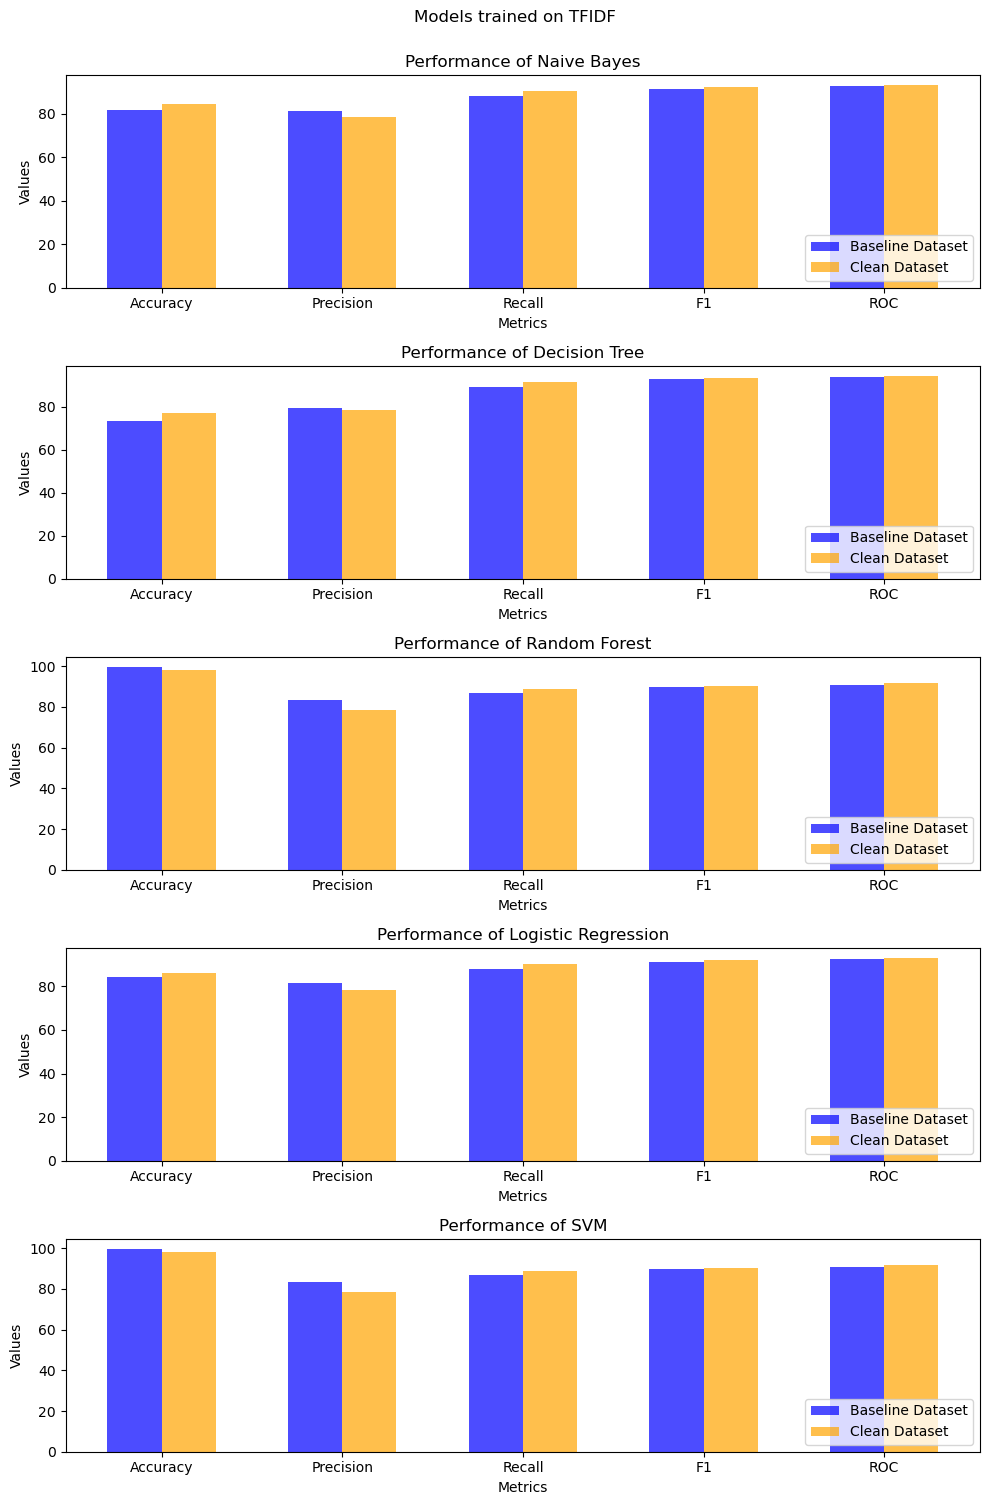

In [37]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC']
baseline_data = np.array([base_results_TFIDF['Accuracy'], base_results_TFIDF['Precision'], 
                          base_results_TFIDF['Recall'], base_results_TFIDF['F1'], base_results_TFIDF['Recall']])
clean_data = np.array([clean_results_TFIDF['Accuracy'], clean_results_TFIDF['Precision'],
                       clean_results_TFIDF['Recall'], clean_results_TFIDF['F1'], clean_results_TFIDF['Recall']])

# Types of models
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM']

# Number of models
num_models = len(models)
# Set Bar width
bar_width = 0.3

# Plotting subplots for each model
fig, axes = plt.subplots(nrows=num_models, ncols=1, figsize=(10, 15))

for i, model in enumerate(models):
    ax = axes[i]
    
    # Plotting bars for each metric for Dataset 1
    ax.bar(np.arange(len(metrics)), baseline_data[i, :], width=bar_width, label=f'Baseline Dataset', color='blue', alpha=0.7)
    
    # Plotting bars for each metric for Dataset 2
    ax.bar(np.arange(len(metrics)) + bar_width, clean_data[i, :], width=bar_width, label=f'Clean Dataset', color='orange', alpha=0.7)

    # Add labels, title, and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(f'Performance of {model}')
    ax.set_xticks(np.arange(len(metrics)) + bar_width / 2)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Standardize legends to show at bottom right
    axes[i].legend(bbox_to_anchor=(1, 0), loc='lower right')
    
# Adjust layout and show the plot
plt.suptitle('Models trained on TFIDF', x=0.52, y=1)
plt.tight_layout()

plt.show()

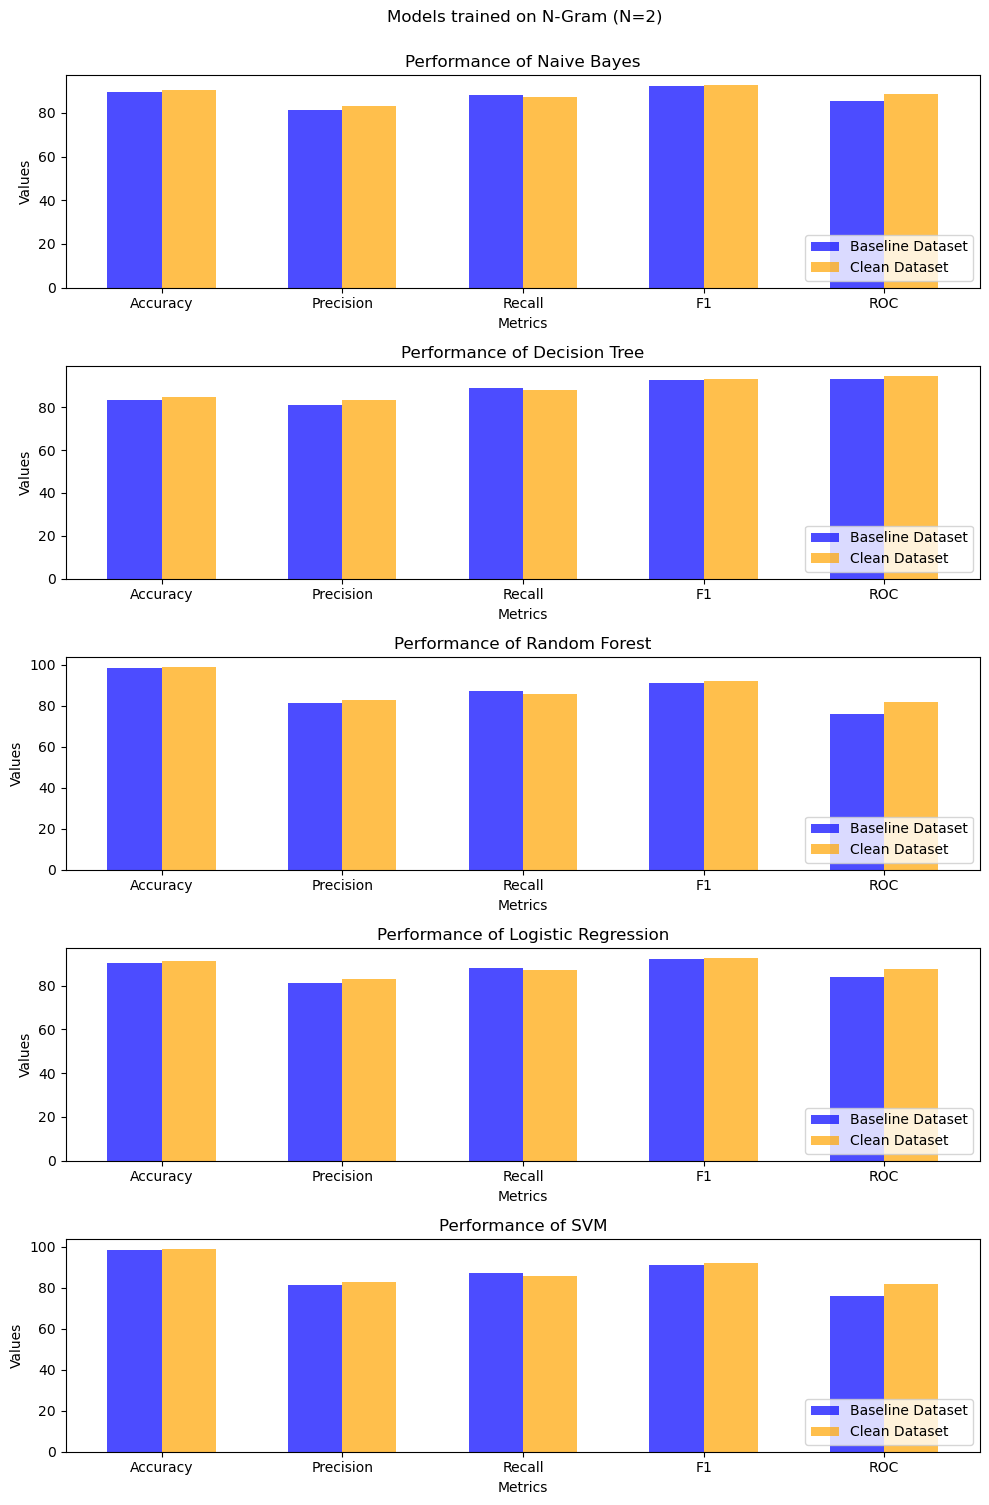

In [40]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC']
baseline_data = np.array([base_results_ngram['Accuracy'], base_results_ngram['Precision'], 
                          base_results_ngram['Recall'], base_results_ngram['F1'], base_results_ngram['Recall']])
clean_data = np.array([clean_results_ngram['Accuracy'], clean_results_ngram['Precision'],
                       clean_results_ngram['Recall'], clean_results_ngram['F1'], clean_results_ngram['Recall']])

# Types of models
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM']

# Number of models
num_models = len(models)
# Set Bar width
bar_width = 0.3

# Plotting subplots for each model
fig, axes = plt.subplots(nrows=num_models, ncols=1, figsize=(10, 15))

for i, model in enumerate(models):
    ax = axes[i]
    
    # Plotting bars for each metric for Dataset 1
    ax.bar(np.arange(len(metrics)), baseline_data[i, :], width=bar_width, label=f'Baseline Dataset', color='blue', alpha=0.7)
    
    # Plotting bars for each metric for Dataset 2
    ax.bar(np.arange(len(metrics)) + bar_width, clean_data[i, :], width=bar_width, label=f'Clean Dataset', color='orange', alpha=0.7)

    # Add labels, title, and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(f'Performance of {model}')
    ax.set_xticks(np.arange(len(metrics)) + bar_width / 2)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Standardize legends to show at bottom right
    axes[i].legend(bbox_to_anchor=(1, 0), loc='lower right')
    
# Adjust layout and show the plot
plt.suptitle('Models trained on N-Gram (N=2)', x=0.53, y=1)
plt.tight_layout()
plt.show()

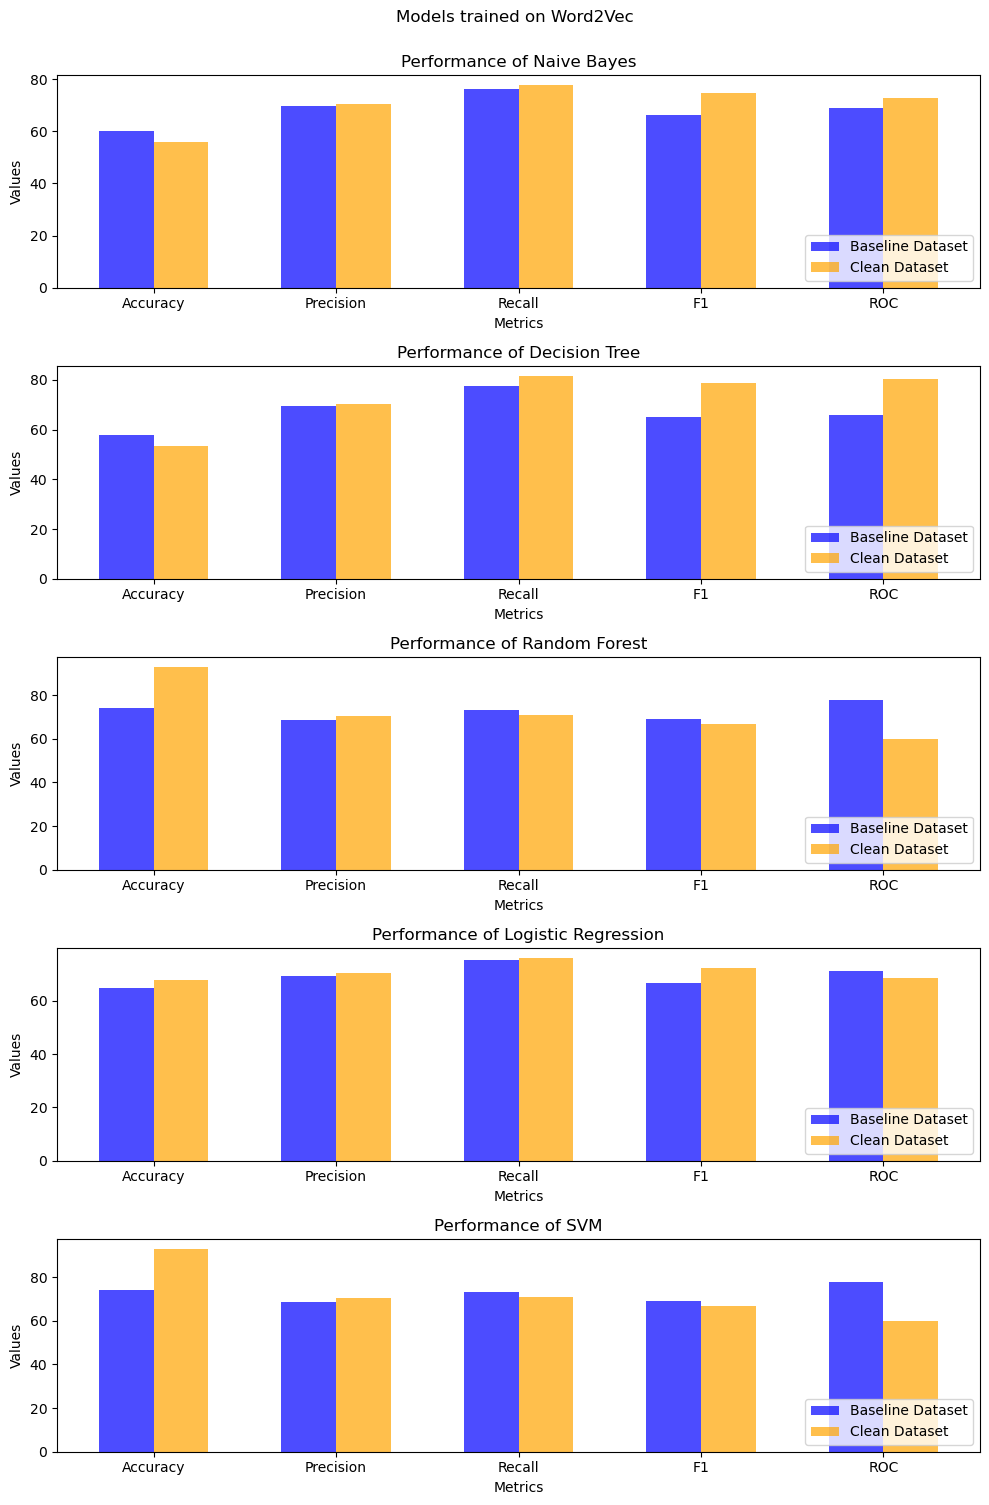

In [42]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC']
baseline_data = np.array([base_results_w2v['Accuracy'], base_results_w2v['Precision'], 
                          base_results_w2v['Recall'], base_results_w2v['F1'], base_results_w2v['Recall']])
clean_data = np.array([clean_results_w2v['Accuracy'], clean_results_w2v['Precision'],
                       clean_results_w2v['Recall'], clean_results_w2v['F1'], clean_results_w2v['Recall']])

# Types of models
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM']

# Number of models
num_models = len(models)
# Set Bar width
bar_width = 0.3

# Plotting subplots for each model
fig, axes = plt.subplots(nrows=num_models, ncols=1, figsize=(10, 15))

for i, model in enumerate(models):
    ax = axes[i]
    
    # Plotting bars for each metric for Dataset 1
    ax.bar(np.arange(len(metrics)), baseline_data[i, :], width=bar_width, label=f'Baseline Dataset', color='blue', alpha=0.7)
    
    # Plotting bars for each metric for Dataset 2
    ax.bar(np.arange(len(metrics)) + bar_width, clean_data[i, :], width=bar_width, label=f'Clean Dataset', color='orange', alpha=0.7)

    # Add labels, title, and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(f'Performance of {model}')
    ax.set_xticks(np.arange(len(metrics)) + bar_width / 2)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Standardize legends to show at bottom right
    axes[i].legend(bbox_to_anchor=(1, 0), loc='lower right')
    
# Adjust layout and show the plot
plt.suptitle('Models trained on Word2Vec', x=0.52, y=1)
plt.tight_layout()
plt.show()

## Visualizing the perfomance using a confusion matrix

#### Models using TF-IDF Confusion Matrix

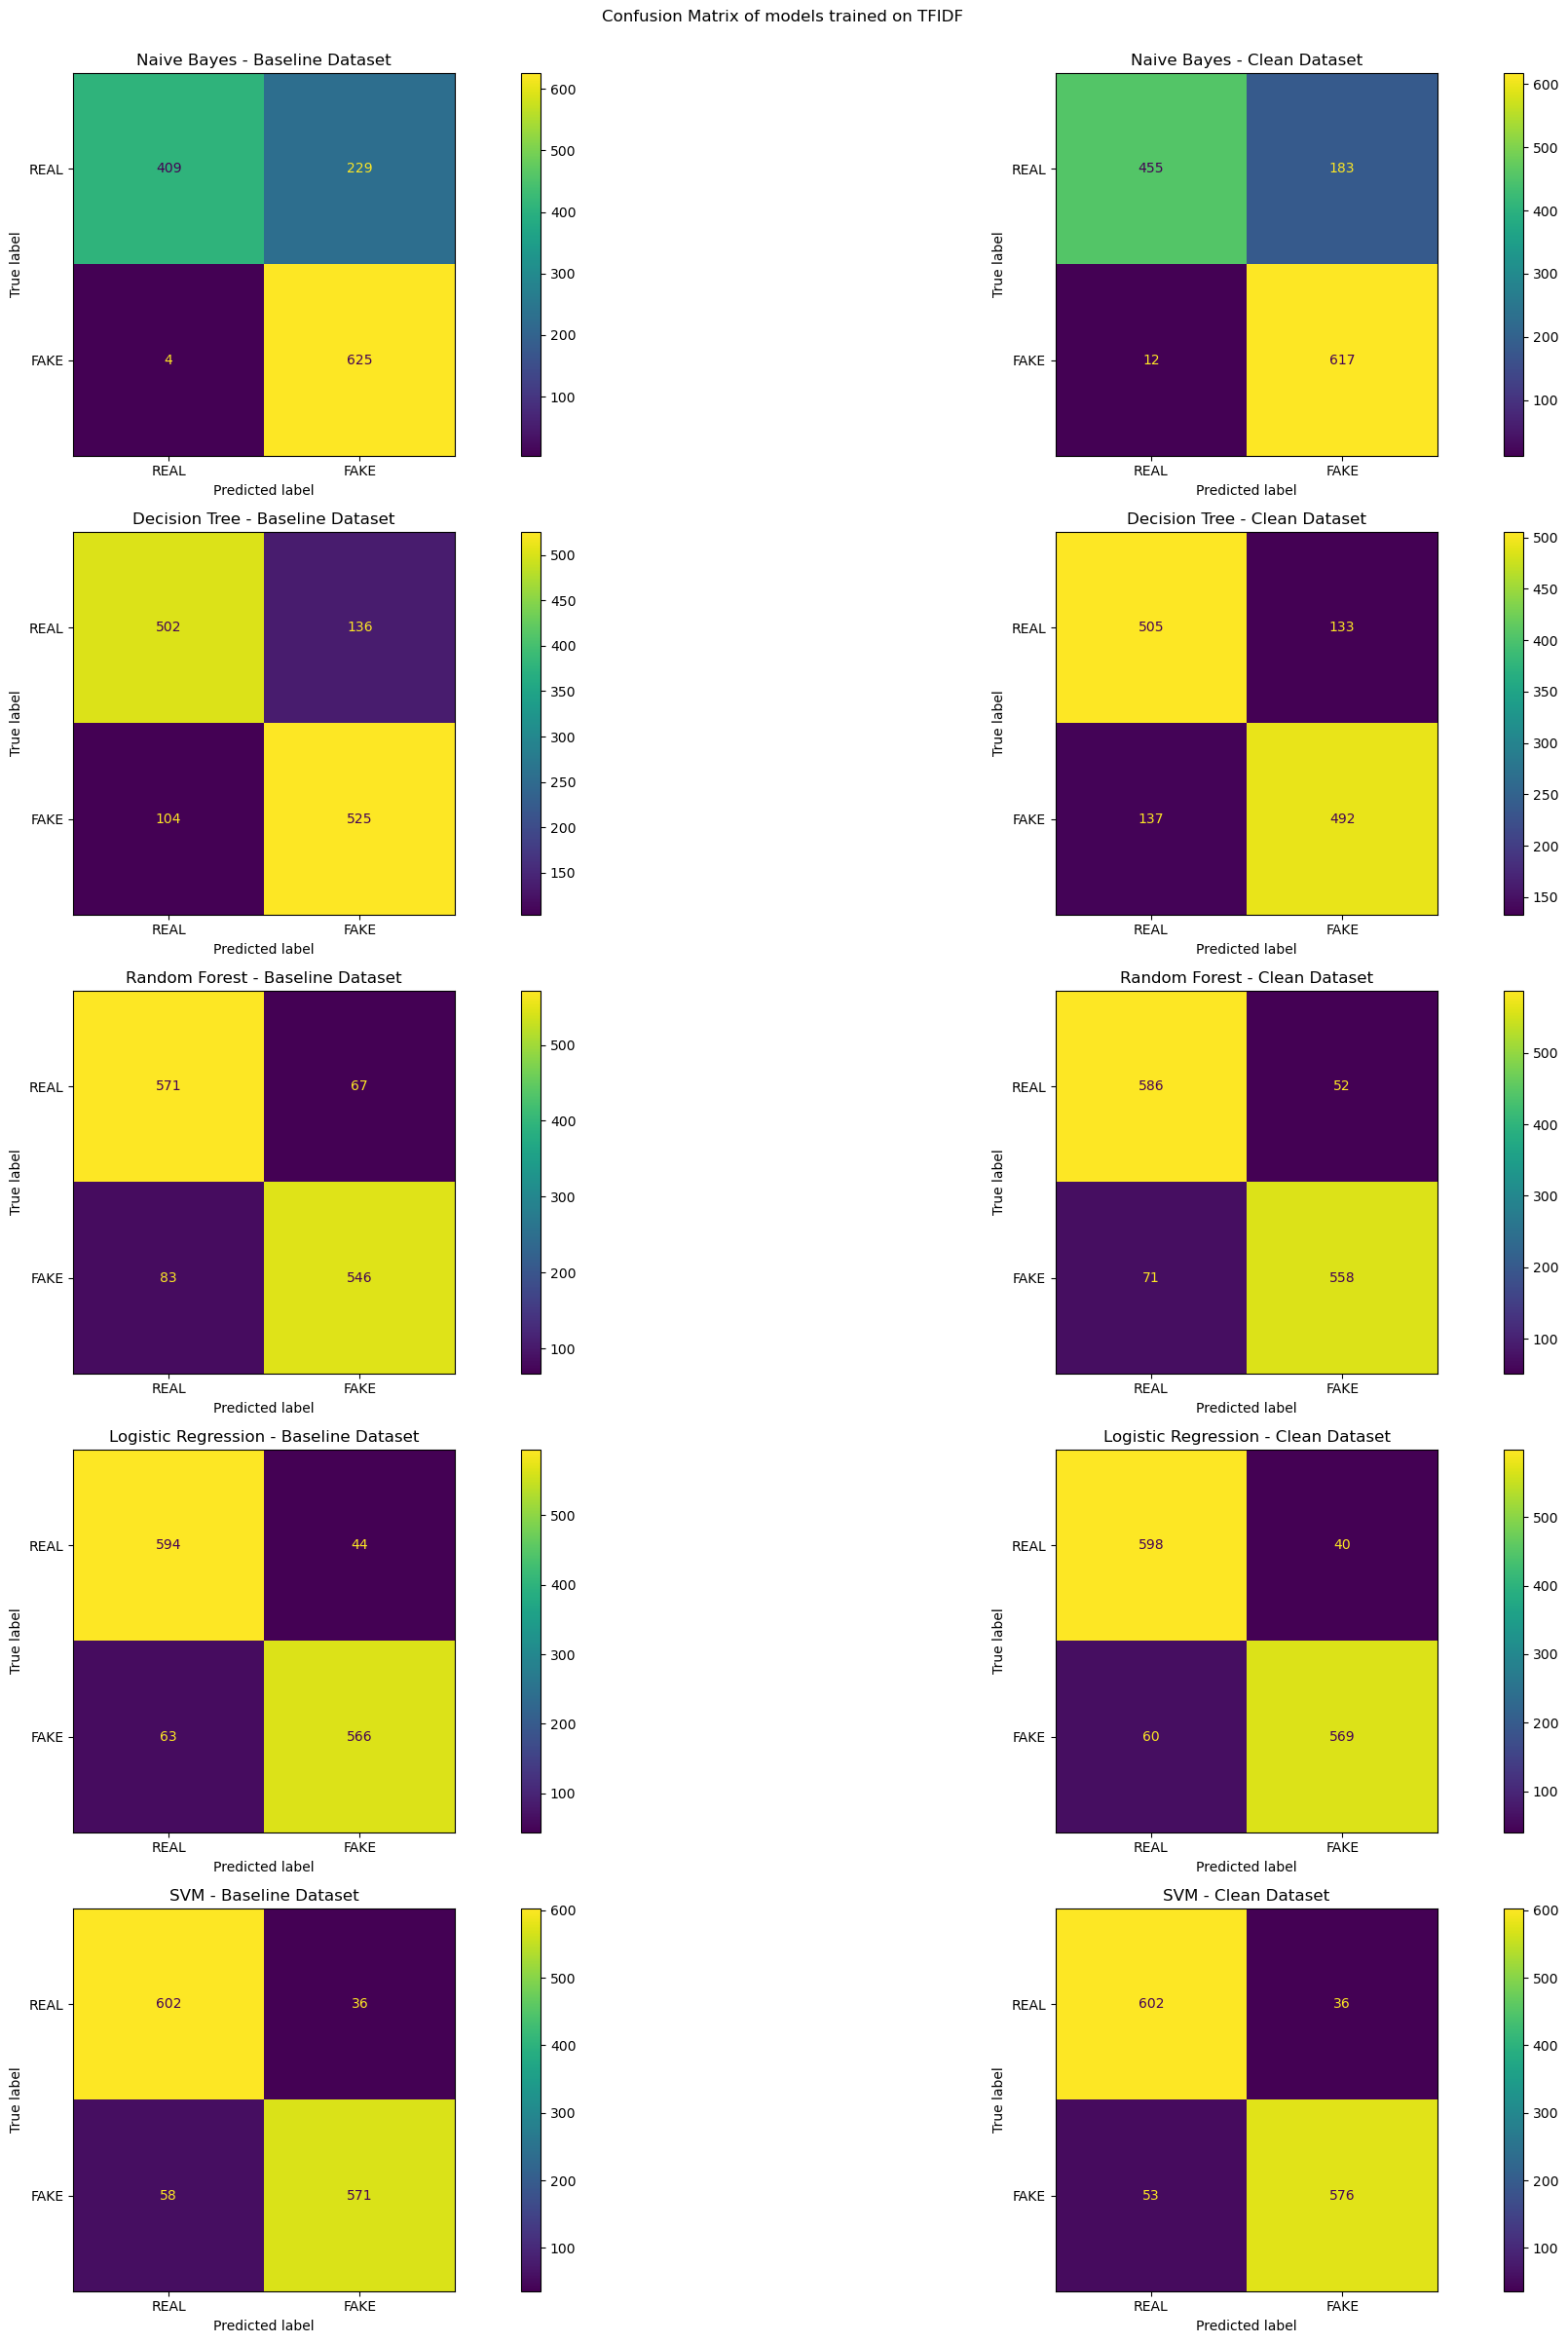

In [52]:
# Plotting subplots
fig, axes = plt.subplots(5, 2, figsize=(24, 24))

# Create the confusion matrix for each model
confusion_matrices  = [[base_results_TFIDF['CM'][0], clean_results_TFIDF['CM'][0]],
                       [base_results_TFIDF['CM'][1], clean_results_TFIDF['CM'][1]],
                       [base_results_TFIDF['CM'][2], clean_results_TFIDF['CM'][2]],
                       [base_results_TFIDF['CM'][3], clean_results_TFIDF['CM'][3]],
                       [base_results_TFIDF['CM'][4], clean_results_TFIDF['CM'][4]]]

# Create the confusion matrix displays for each model
for i, (base, clean) in enumerate(confusion_matrices):
    # Create the confusion matrix displays for each dataset
    base_display = ConfusionMatrixDisplay(base, display_labels=['REAL', 'FAKE'])
    clean_display = ConfusionMatrixDisplay(clean, display_labels=['REAL', 'FAKE'])

    # Plot the Confusion Matrices
    axes[i, 0].set_title(f'{models[i]} - Baseline Dataset')
    base_display.plot(ax=axes[i, 0])
    
    axes[i, 1].set_title(f'{models[i]} - Clean Dataset')
    clean_display.plot(ax=axes[i, 1])

# Adjust layout
plt.suptitle('Confusion Matrix of models trained on TFIDF', x=0.6, y=1)
plt.tight_layout()
plt.show()

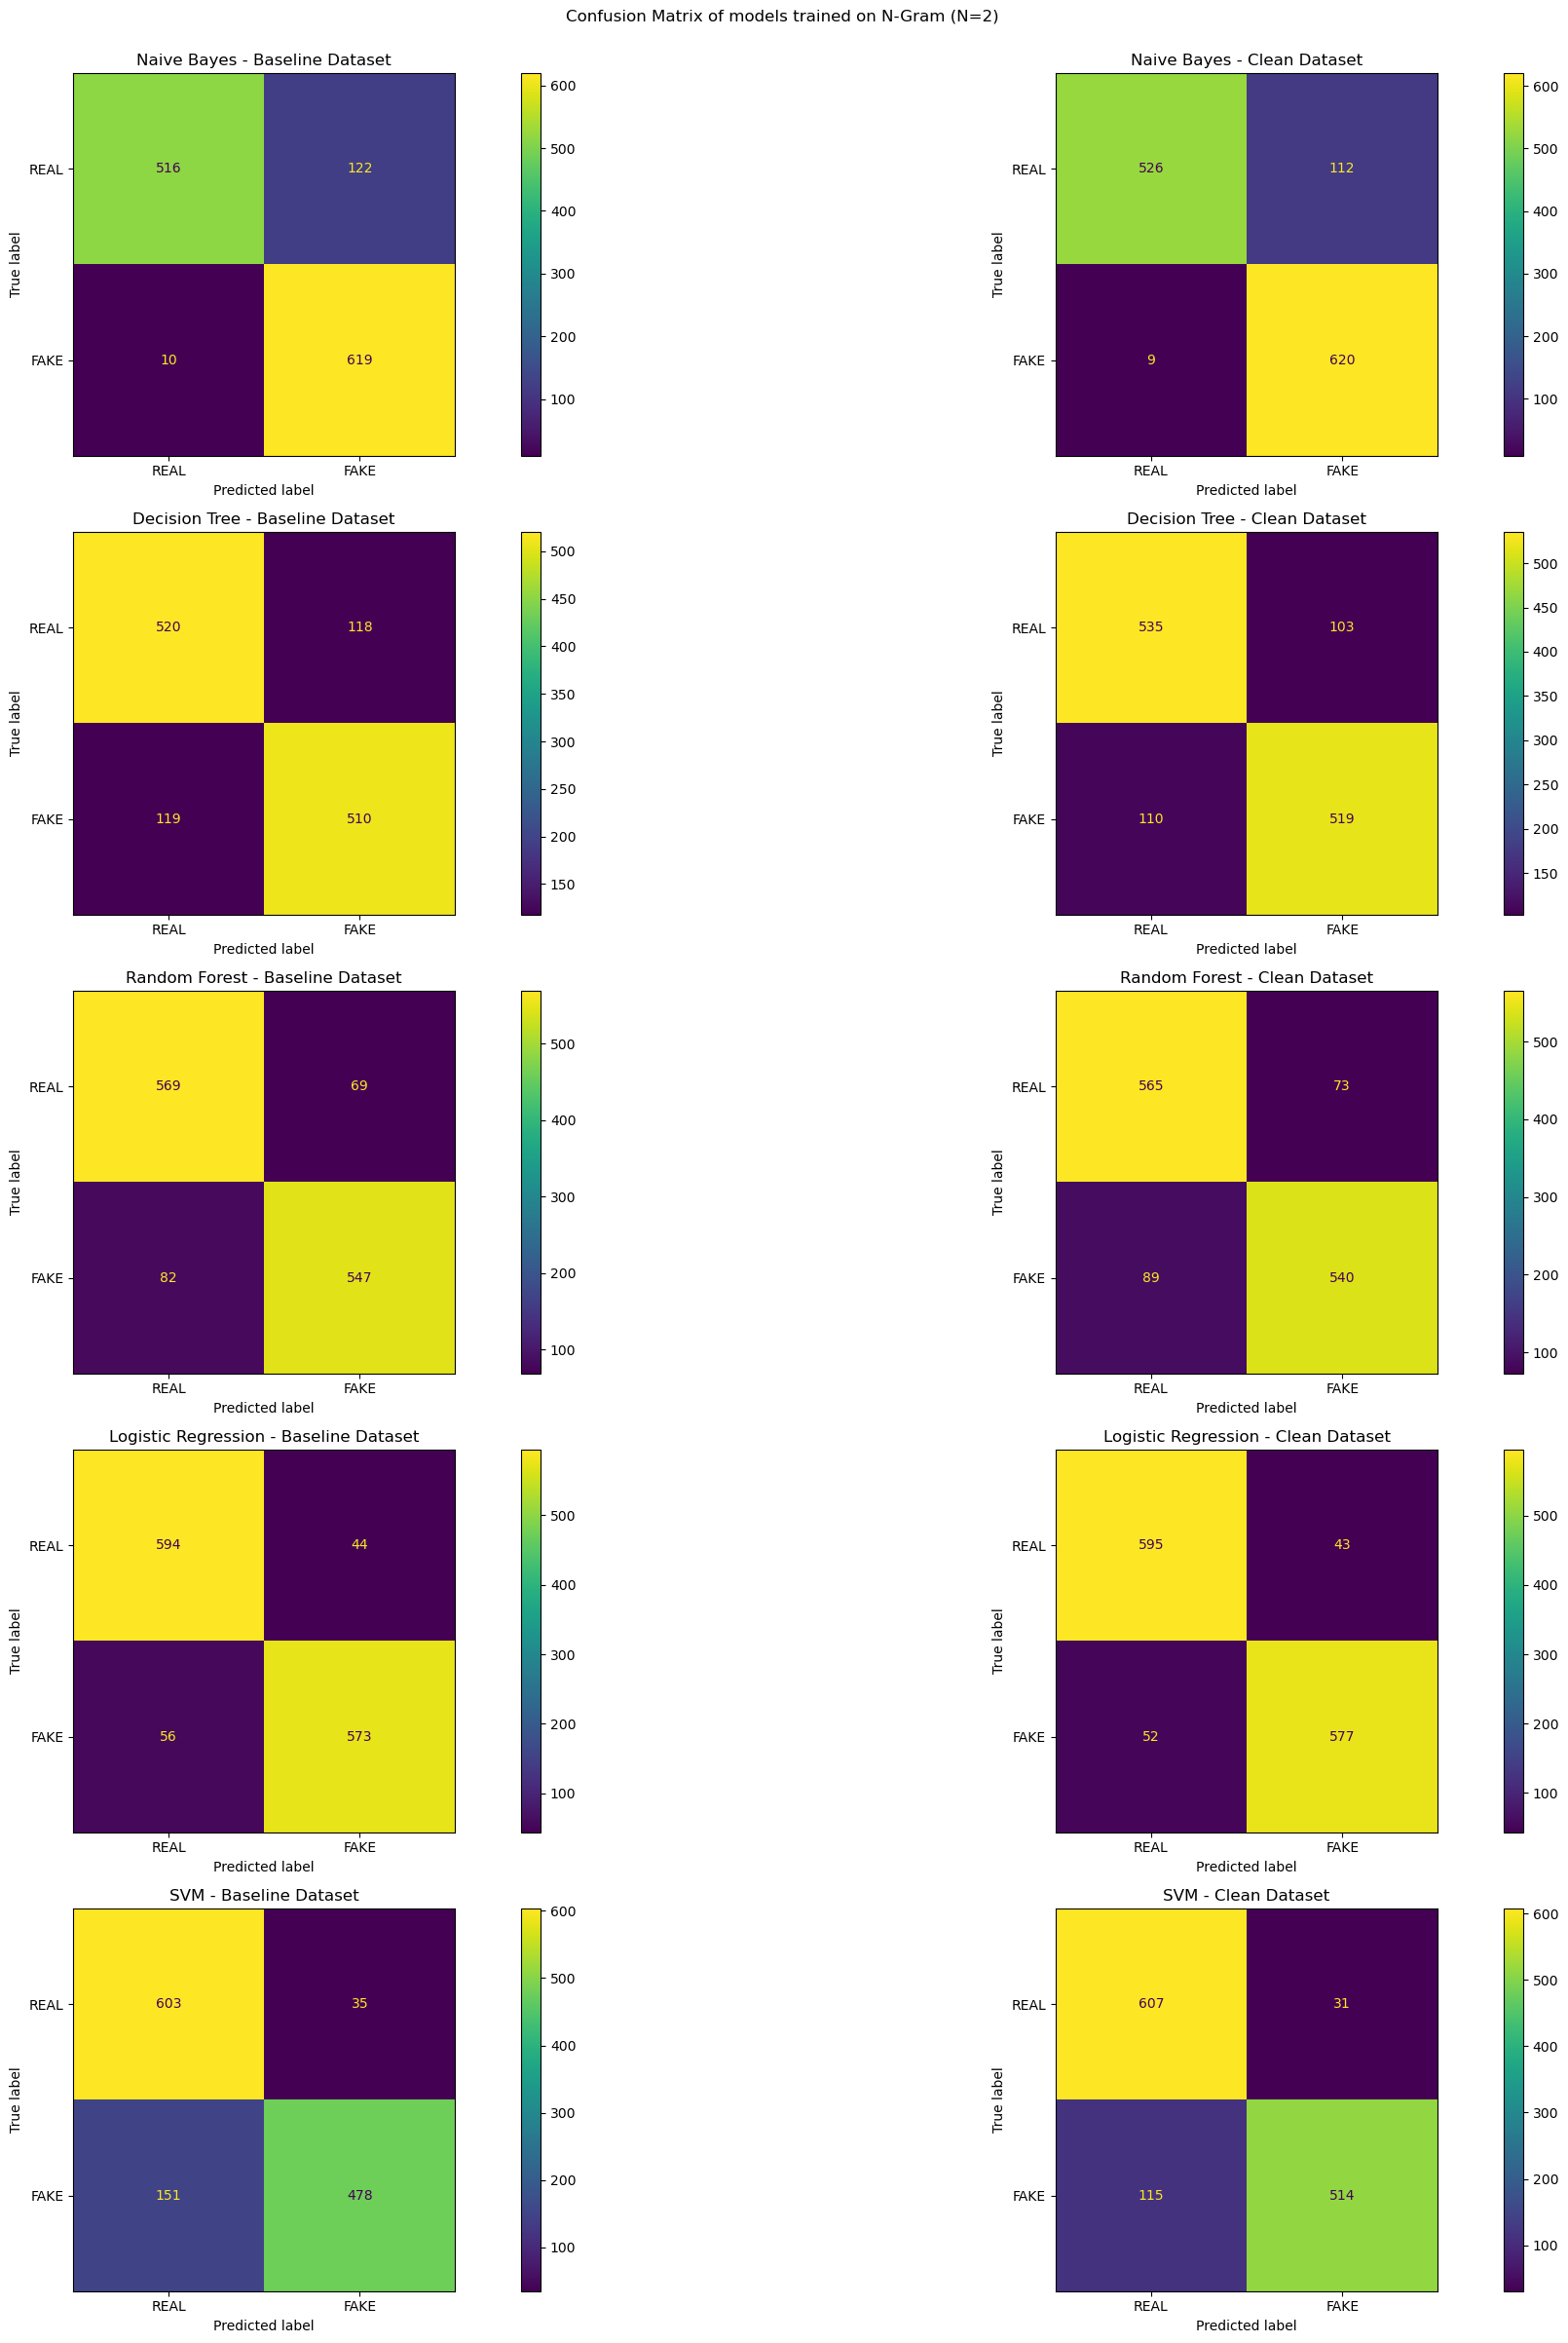

In [50]:
# Plotting subplots
fig, axes = plt.subplots(5, 2, figsize=(24, 24))

# Create the confusion matrix for each model
confusion_matrices  = [[base_results_ngram['CM'][0], clean_results_ngram['CM'][0]],
                       [base_results_ngram['CM'][1], clean_results_ngram['CM'][1]],
                       [base_results_ngram['CM'][2], clean_results_ngram['CM'][2]],
                       [base_results_ngram['CM'][3], clean_results_ngram['CM'][3]],
                       [base_results_ngram['CM'][4], clean_results_ngram['CM'][4]]]

# Create the confusion matrix displays for each model
for i, (base, clean) in enumerate(confusion_matrices):
    # Create the confusion matrix displays for each dataset
    base_display = ConfusionMatrixDisplay(base, display_labels=['REAL', 'FAKE'])
    clean_display = ConfusionMatrixDisplay(clean, display_labels=['REAL', 'FAKE'])

    # Plot the Confusion Matrices
    axes[i, 0].set_title(f'{models[i]} - Baseline Dataset')
    base_display.plot(ax=axes[i, 0])

    axes[i, 1].set_title(f'{models[i]} - Clean Dataset')
    clean_display.plot(ax=axes[i, 1])

# Adjust layout
plt.suptitle('Confusion Matrix of models trained on N-Gram (N=2)', x=0.6, y=1)
plt.tight_layout()

plt.show()

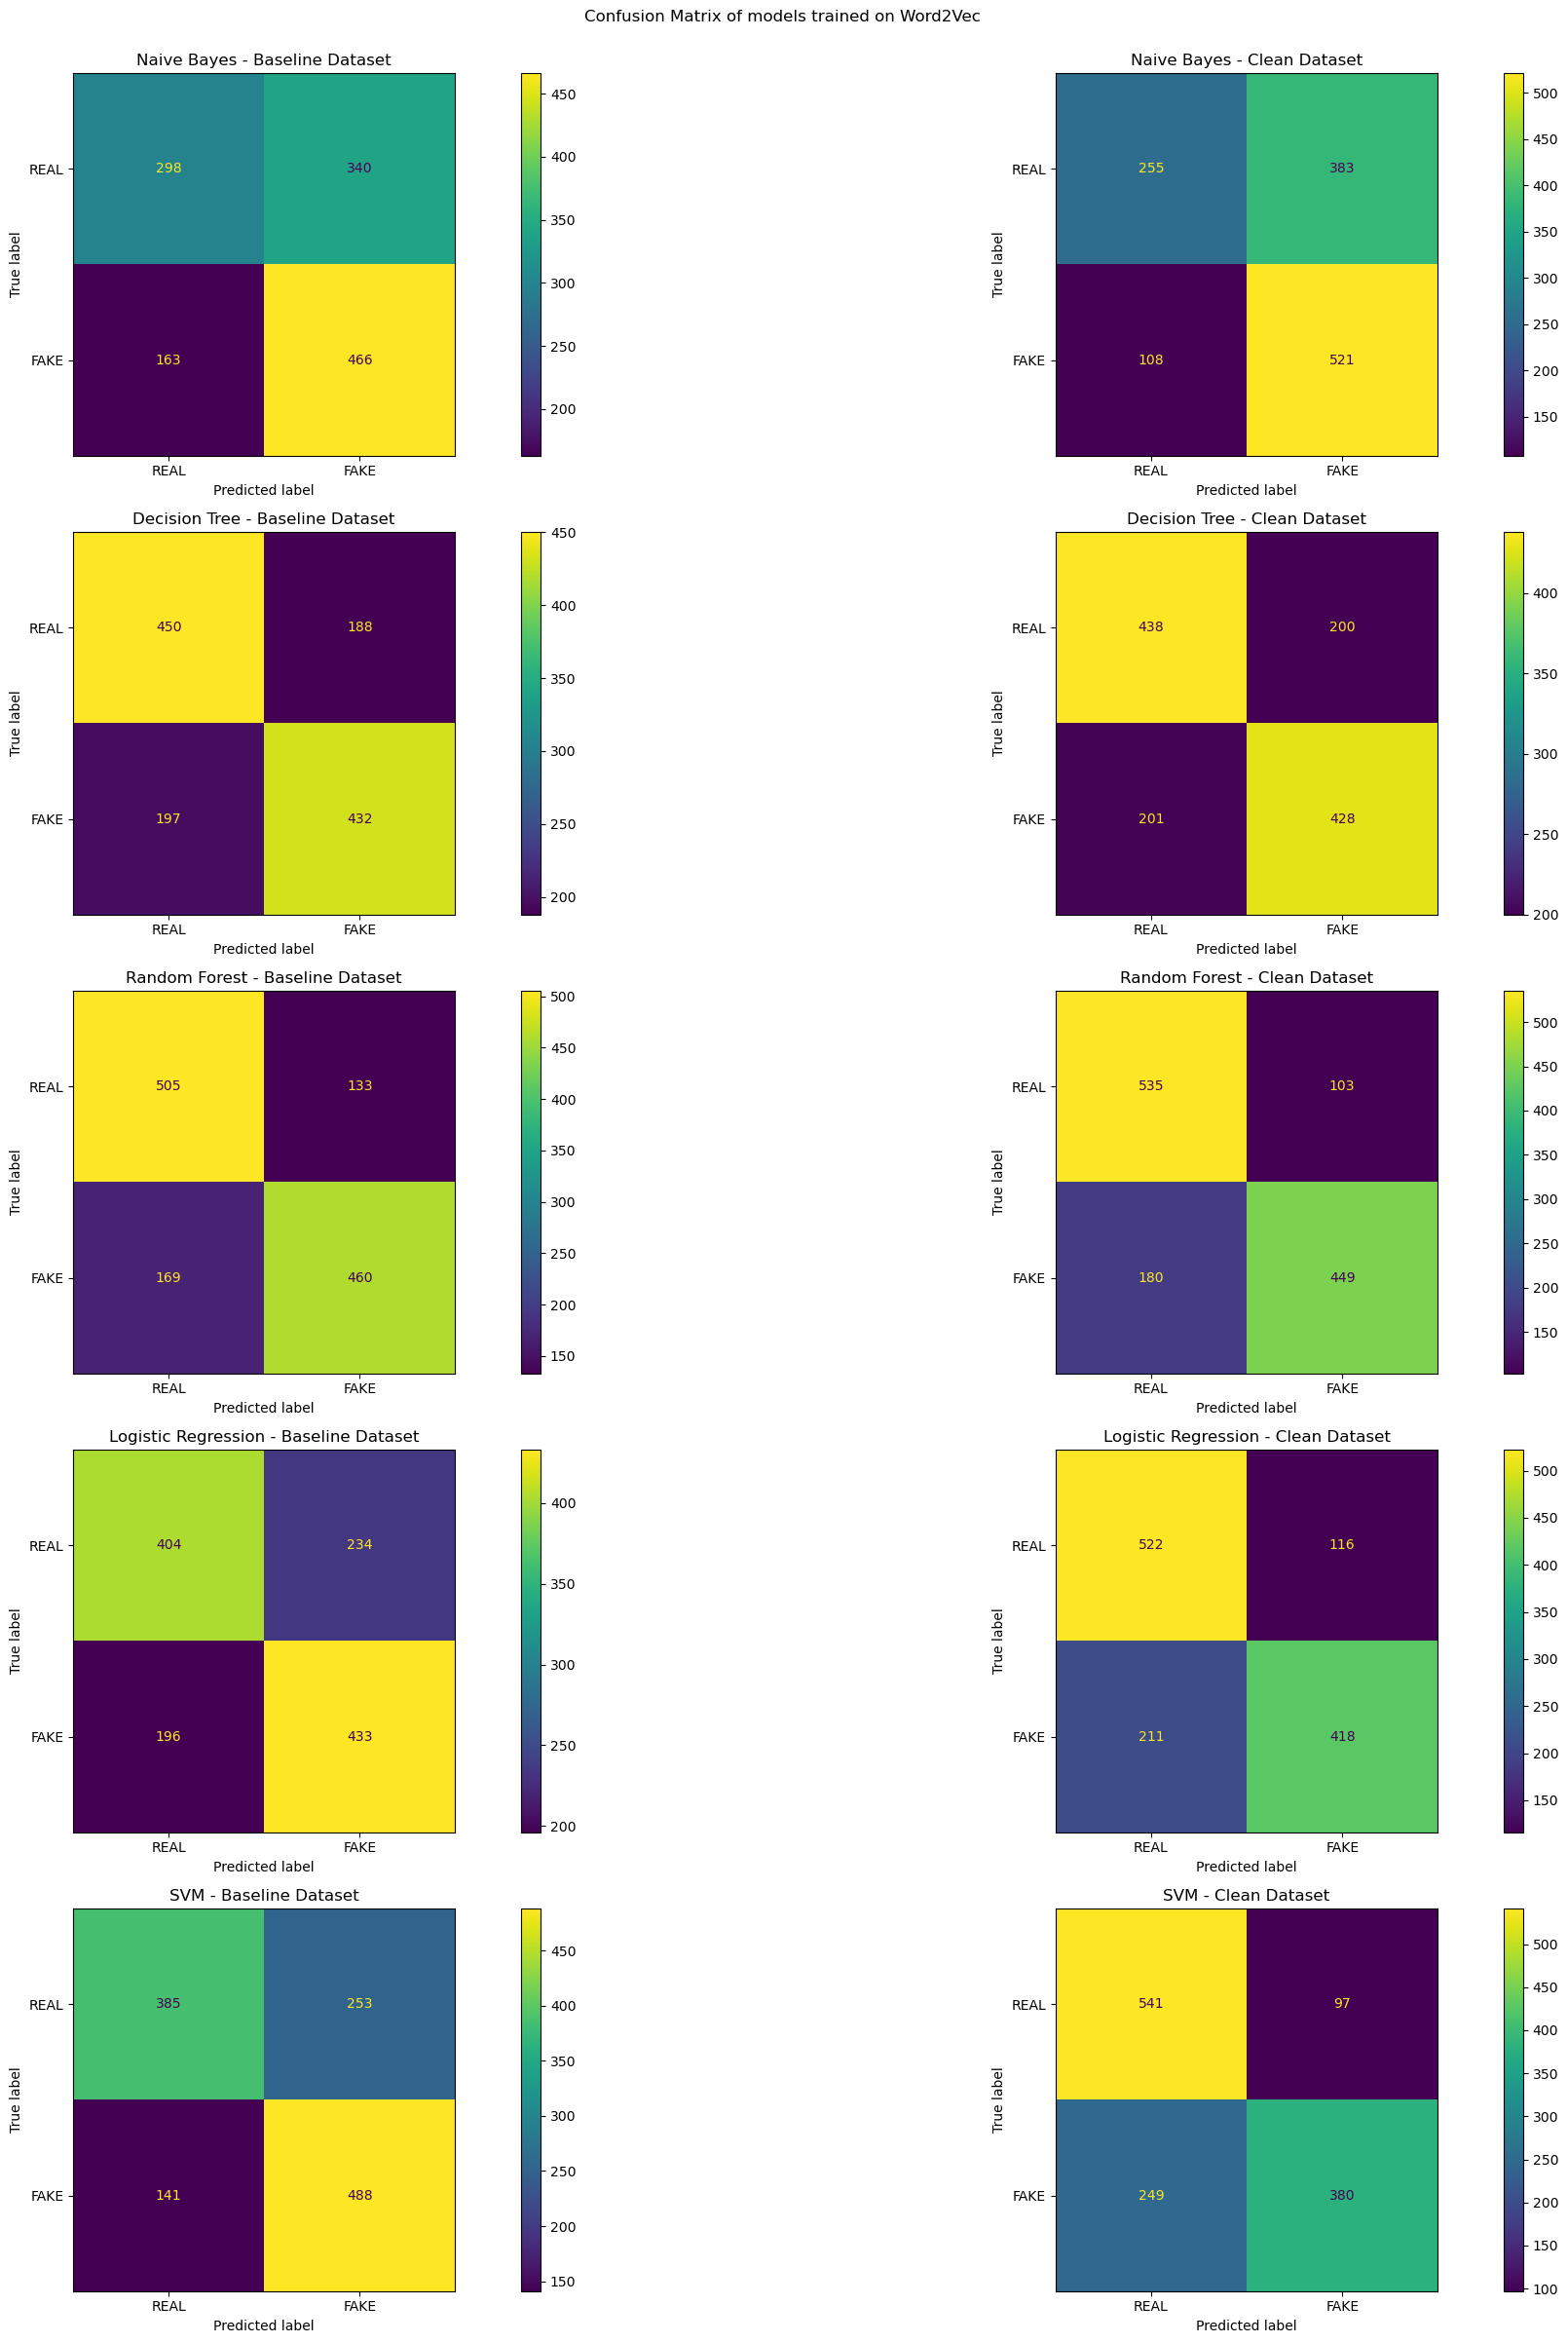

In [89]:
# Plotting subplots
fig, axes = plt.subplots(5, 2, figsize=(24, 24))

# Create the confusion matrix for each model
confusion_matrices  = [[base_results_w2v['CM'][0], clean_results_w2v['CM'][0]],
                       [base_results_w2v['CM'][1], clean_results_w2v['CM'][1]],
                       [base_results_w2v['CM'][2], clean_results_w2v['CM'][2]],
                       [base_results_w2v['CM'][3], clean_results_w2v['CM'][3]],
                       [base_results_w2v['CM'][4], clean_results_w2v['CM'][4]]]

# Create the confusion matrix displays for each model
for i, (base, clean) in enumerate(confusion_matrices):
    # Create the confusion matrix displays for each dataset
    base_display = ConfusionMatrixDisplay(base, display_labels=['REAL', 'FAKE'])
    clean_display = ConfusionMatrixDisplay(clean, display_labels=['REAL', 'FAKE'])

    # Plot the Confusion Matrices
    axes[i, 0].set_title(f'{models[i]} - Baseline Dataset')
    base_display.plot(ax=axes[i, 0])

    axes[i, 1].set_title(f'{models[i]} - Clean Dataset')
    clean_display.plot(ax=axes[i, 1])

# Adjust layout
plt.suptitle('Confusion Matrix of models trained on Word2Vec', x=0.6, y=1)
plt.tight_layout()

plt.show()

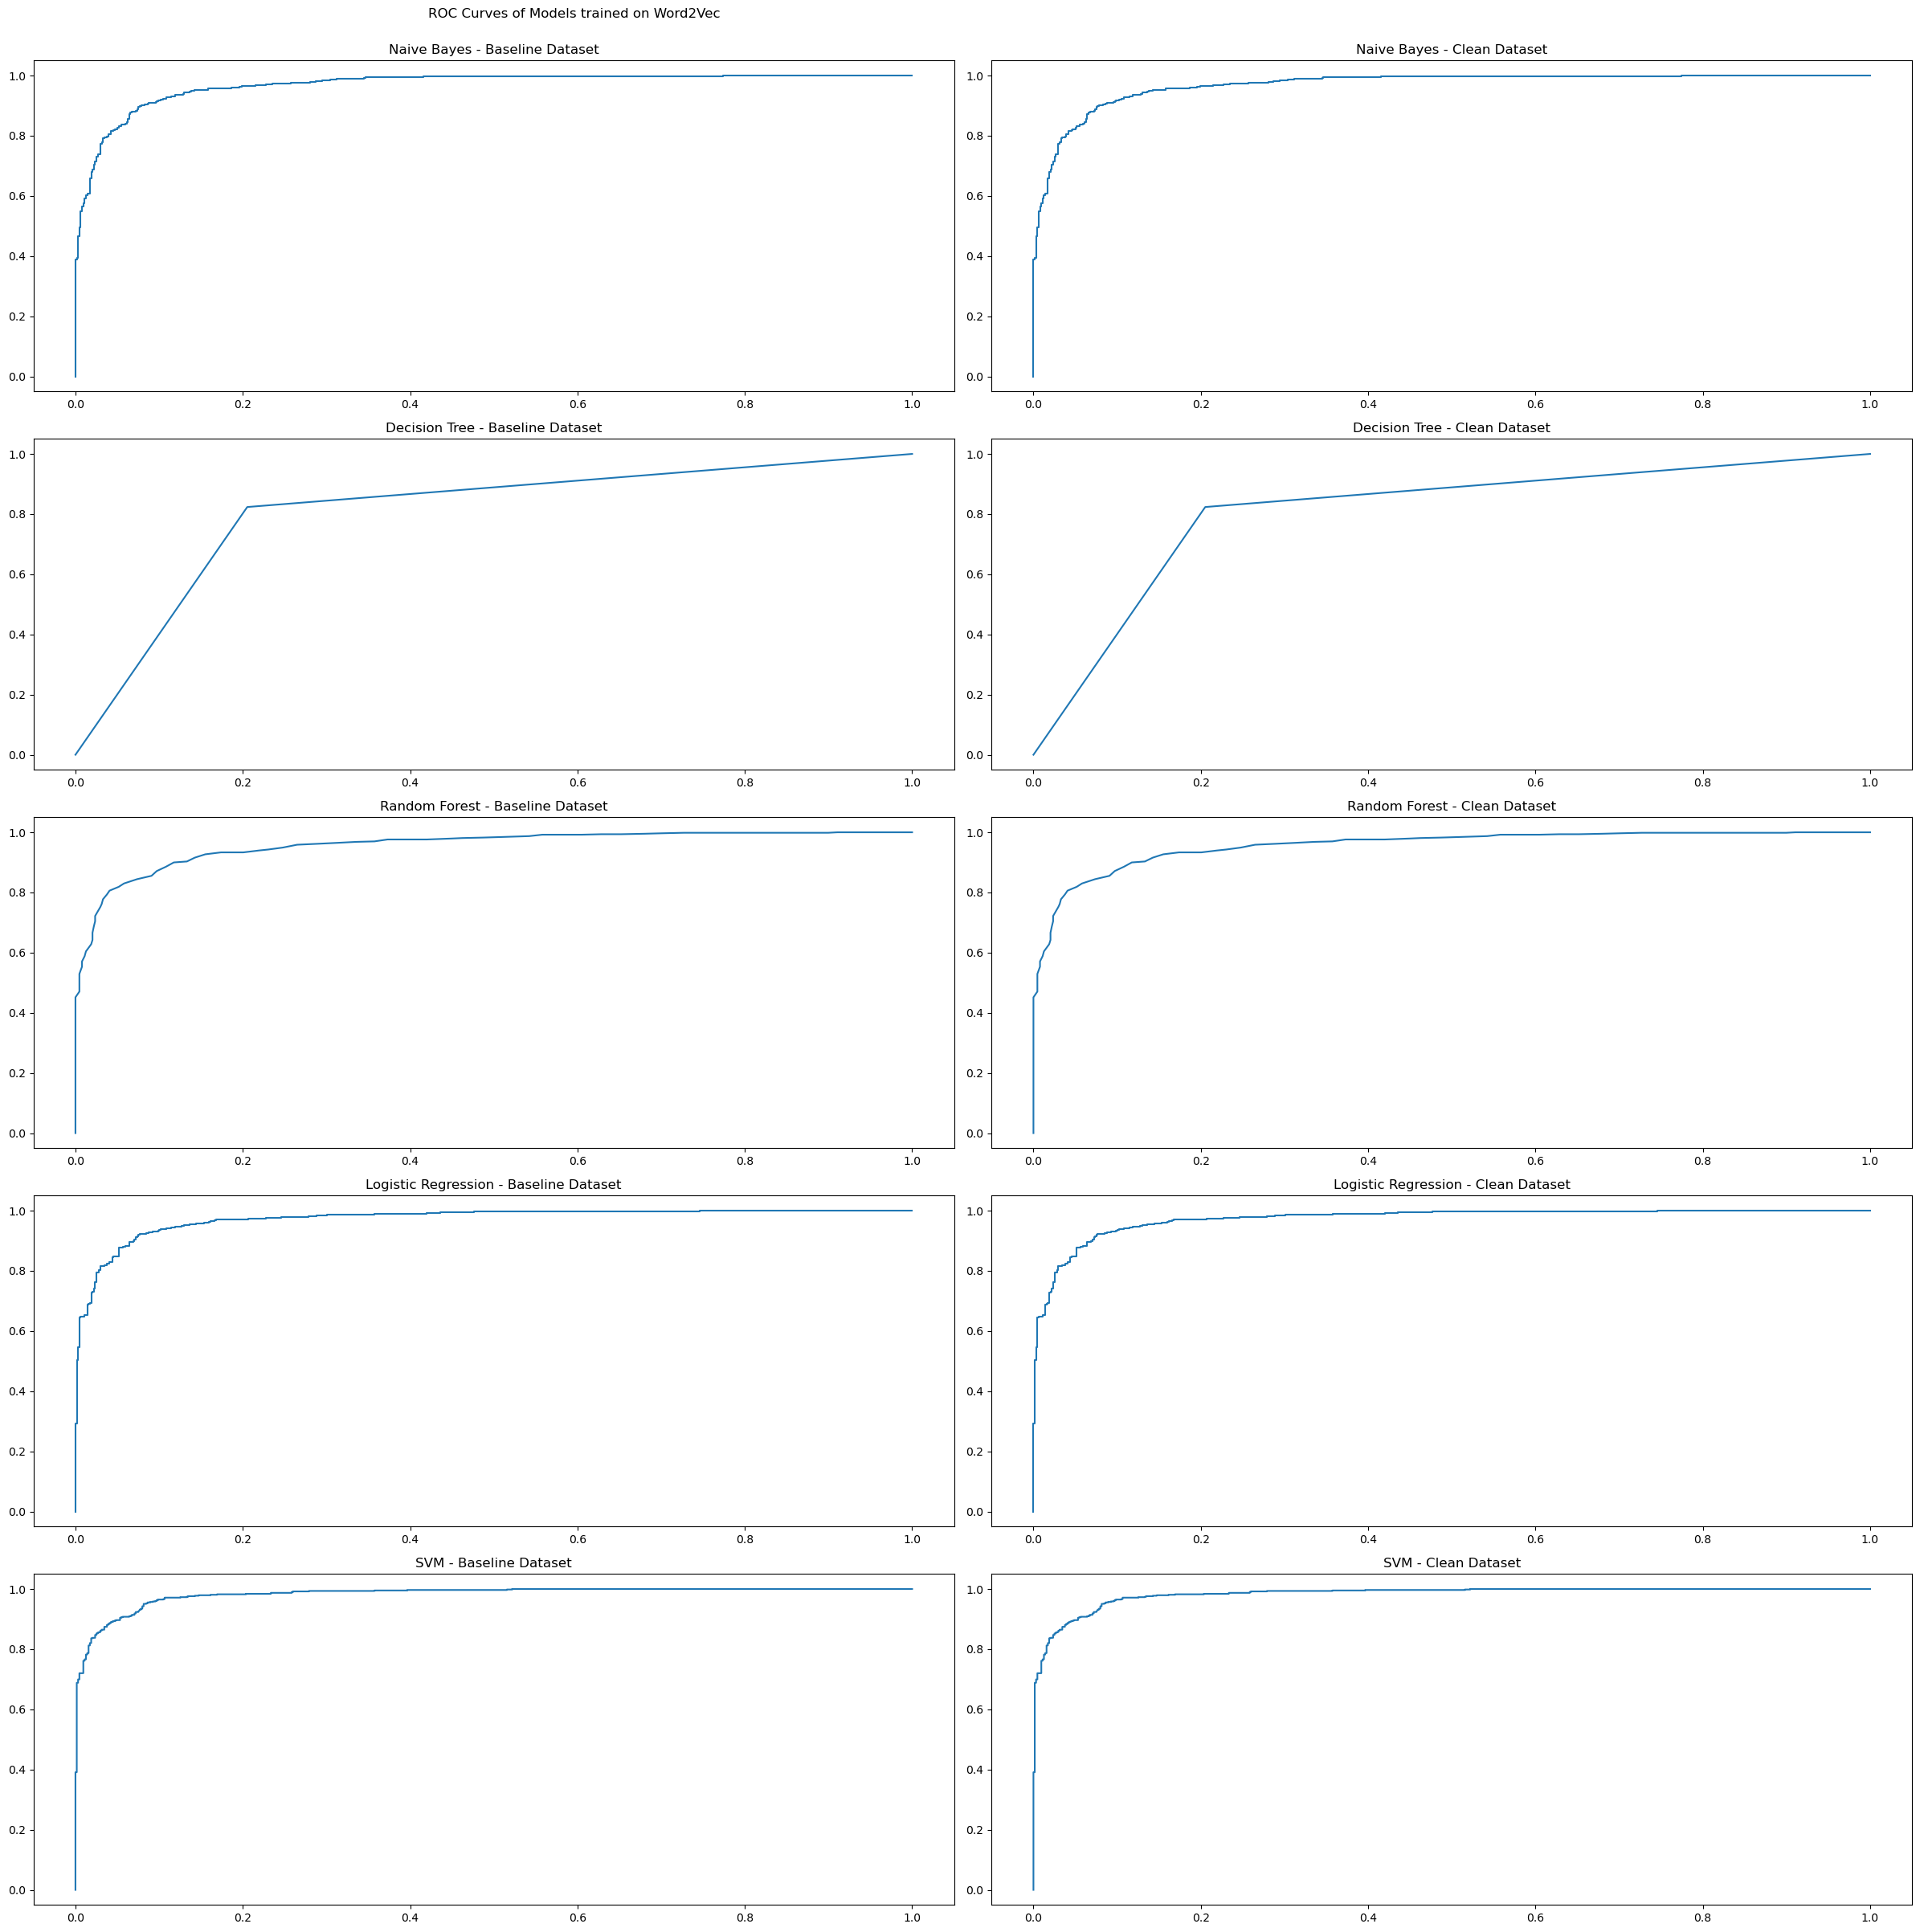

In [104]:
# Plotting subplots
fig, axes = plt.subplots(5, 2, figsize=(24, 24))

rocs  = [[base_results_TFIDF['Curve'][0], clean_results_TFIDF['Curve'][0]],
         [base_results_TFIDF['Curve'][1], clean_results_TFIDF['Curve'][1]],
         [base_results_TFIDF['Curve'][2], clean_results_TFIDF['Curve'][2]],
         [base_results_TFIDF['Curve'][3], clean_results_TFIDF['Curve'][3]],
         [base_results_TFIDF['Curve'][4], clean_results_TFIDF['Curve'][4]]]

for i, (base, clean) in enumerate(rocs):
    # Plot the ROC curve for baseline dataset
    axes[i, 0].set_title(f'{models[i]} - Baseline Dataset')
    axes[i, 0].plot(base[0], base[1], label=f'ROC curve (AUC = {base_results_TFIDF["ROC"][i]:.2f})')

    # Plot the ROC curve for clean dataset
    axes[i, 1].set_title(f'{models[i]} - Clean Dataset')
    axes[i, 1].plot(base[0], base[1], label=f'ROC curve (AUC = {clean_results_TFIDF["ROC"][i]:.2f})')

# Adjust layout
plt.suptitle('ROC Curves of Models trained on Word2Vec', x=0.3, y=1)
plt.tight_layout()

plt.show()

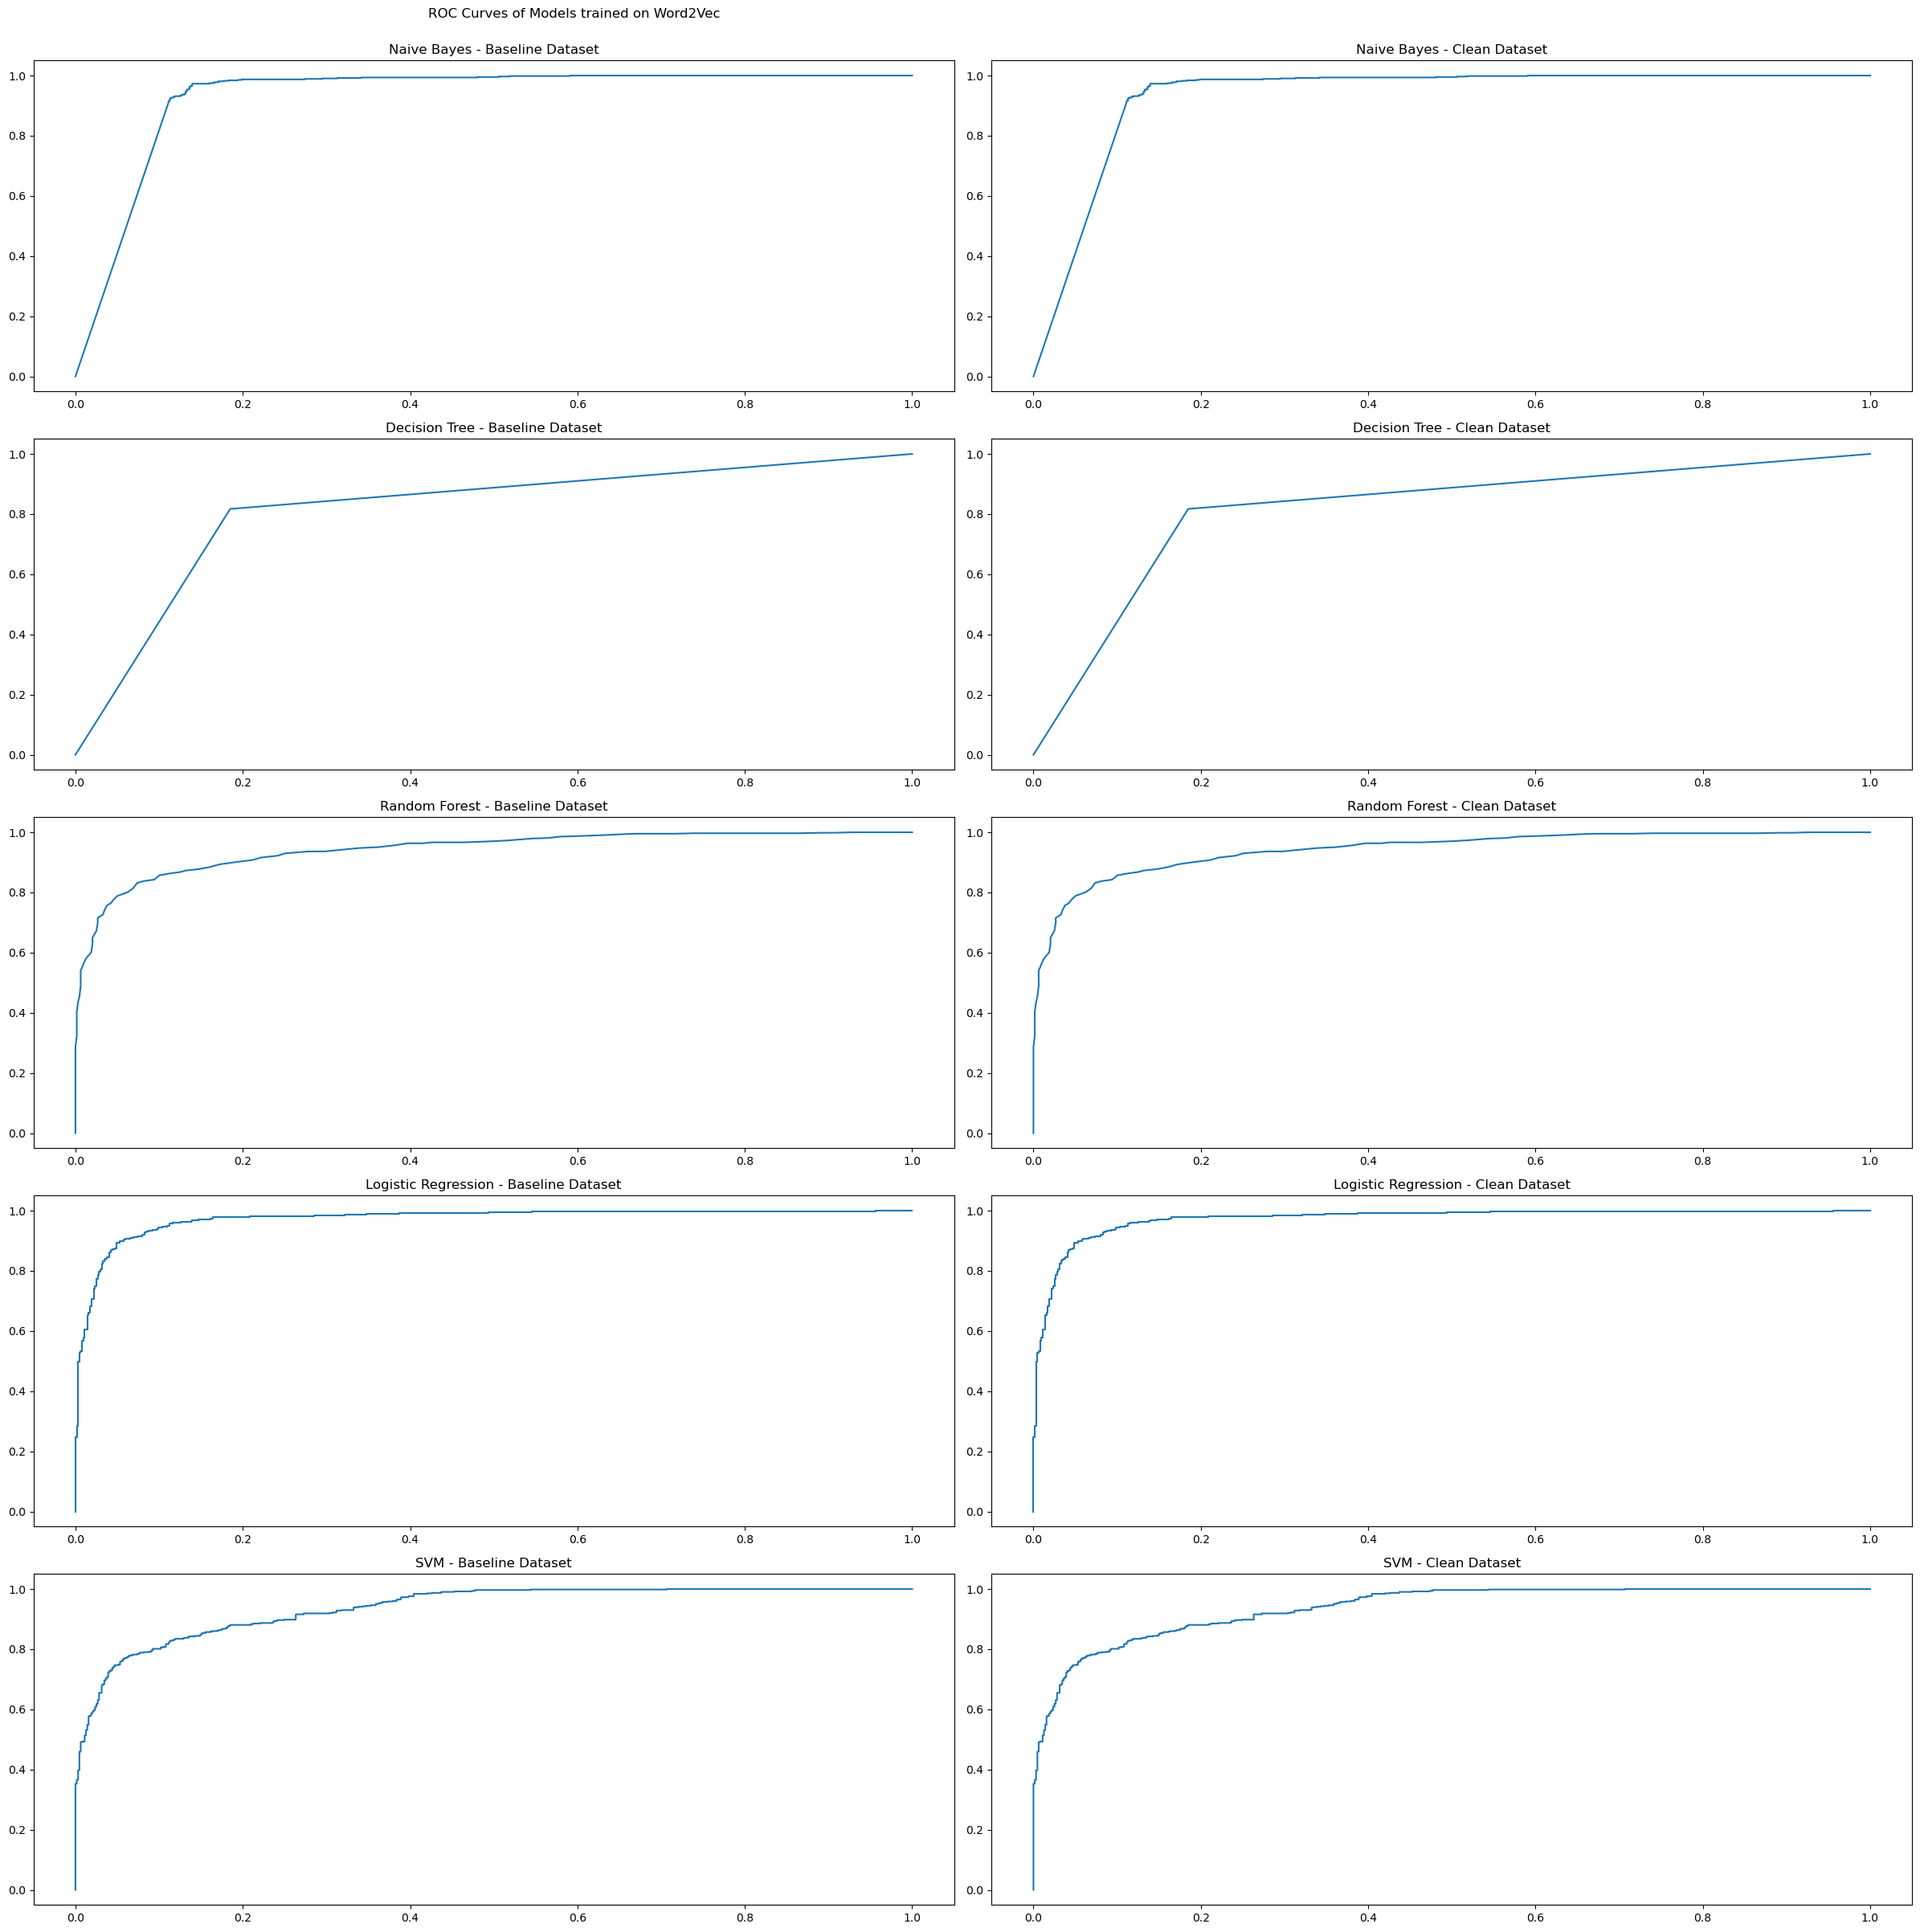

In [105]:
# Plotting subplots
fig, axes = plt.subplots(5, 2, figsize=(24, 24))

rocs  = [[base_results_ngram['Curve'][0], clean_results_ngram['Curve'][0]],
         [base_results_ngram['Curve'][1], clean_results_ngram['Curve'][1]],
         [base_results_ngram['Curve'][2], clean_results_ngram['Curve'][2]],
         [base_results_ngram['Curve'][3], clean_results_ngram['Curve'][3]],
         [base_results_ngram['Curve'][4], clean_results_ngram['Curve'][4]]]

for i, (base, clean) in enumerate(rocs):
    # Plot the ROC curve for baseline dataset
    axes[i, 0].set_title(f'{models[i]} - Baseline Dataset')
    axes[i, 0].plot(base[0], base[1], label=f'ROC curve (AUC = {base_results_ngram["ROC"][i]:.2f})')

    # Plot the ROC curve for clean dataset
    axes[i, 1].set_title(f'{models[i]} - Clean Dataset')
    axes[i, 1].plot(base[0], base[1], label=f'ROC curve (AUC = {clean_results_ngram["ROC"][i]:.2f})')

# Adjust layout
plt.suptitle('ROC Curves of Models trained on Word2Vec', x=0.3, y=1)
plt.tight_layout()

plt.show()

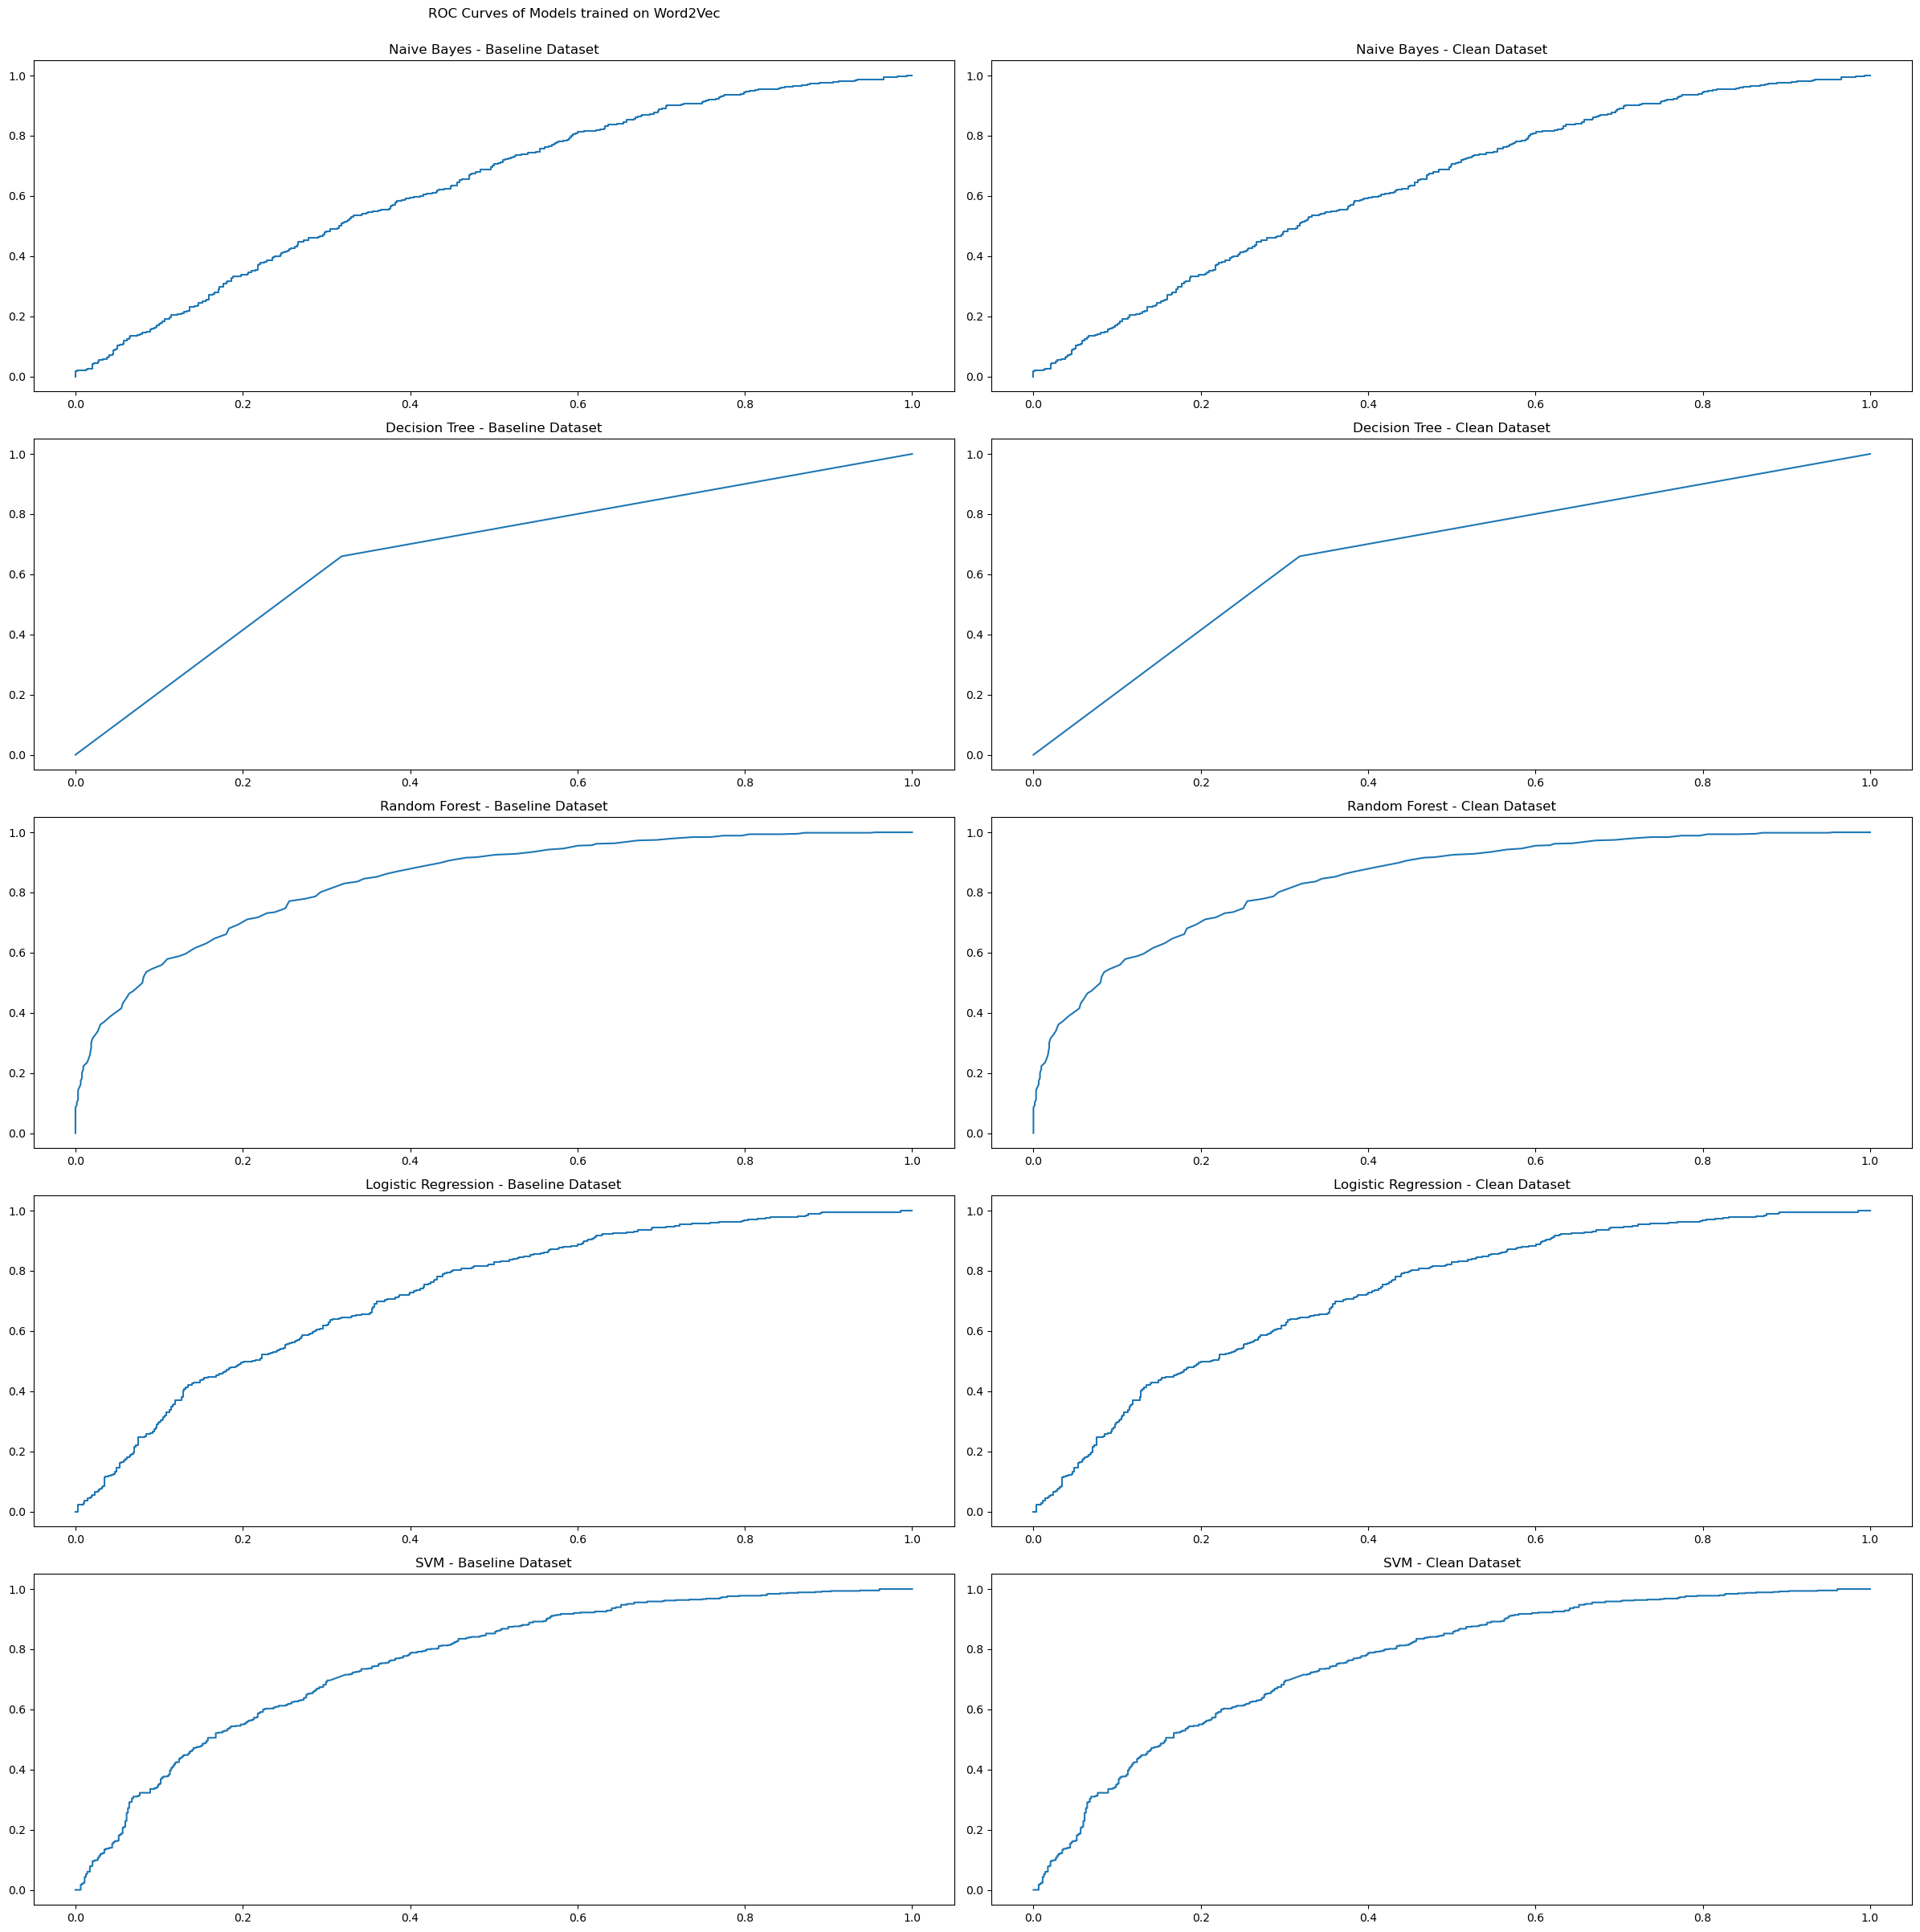

In [106]:
# Plotting subplots
fig, axes = plt.subplots(5, 2, figsize=(24, 24))

rocs  = [[base_results_w2v['Curve'][0], clean_results_w2v['Curve'][0]],
         [base_results_w2v['Curve'][1], clean_results_w2v['Curve'][1]],
         [base_results_w2v['Curve'][2], clean_results_w2v['Curve'][2]],
         [base_results_w2v['Curve'][3], clean_results_w2v['Curve'][3]],
         [base_results_w2v['Curve'][4], clean_results_w2v['Curve'][4]]]

for i, (base, clean) in enumerate(rocs):
    # Plot the ROC curve for baseline dataset
    axes[i, 0].set_title(f'{models[i]} - Baseline Dataset')
    axes[i, 0].plot(base[0], base[1], label=f'ROC curve (AUC = {base_results_w2v["ROC"][i]:.2f})')

    # Plot the ROC curve for clean dataset
    axes[i, 1].set_title(f'{models[i]} - Clean Dataset')
    axes[i, 1].plot(base[0], base[1], label=f'ROC curve (AUC = {clean_results_w2v["ROC"][i]:.2f})')

# Adjust layout
plt.suptitle('ROC Curves of Models trained on Word2Vec', x=0.3, y=1)
plt.tight_layout()

plt.show()

# Conclusion

The objective of this feature prototype 2 was to implement all 5 different machine learning models and all 3 feature extraction methods in order to compare their performance and pick the best model or models to proceed with our final prototype, feature prototype 3, which I believe was well achieved.

I will be which model performs the best in terms of their accuracies for each feature extraction methods and their mean accuracy to pick the best or best few models to move on with. Most of the models are initialized without any hyperparameter (minimal operable state) except for logistic regression where max_iter is set to 1000 else the program will stop when it hits its iteration limits, and SVM has its probability set to true in order for us to extract the y_predict probability to plot our ROC curve.

For models trained on TFIDF feature, SVM achieved highest accuracy amongst the other models across both baseline dataset and clean dataset at 92.58% and 92.58% respectively. This is within our expectation as SVM are well fitted for text classification tasks.

For models trained on N-Gram feature which in this prototype we used bigrams, logistic regression achieved highest accuracy amongst the other models across both at 92.11%. I have decided to consider this result for picking the best model as according to [40] from the report or https://core.ac.uk/download/pdf/234677239.pdf, Kennedy et al. which conducted a test on several models while varying the number of N-grams and it proved diminishing performance. Although bigram may not allow the models to produce the best result, it still serves as a good lower limit.

For models trained on Word2Vec feature, Random Forest achieved highest accuracy amongst the other models across both baseline dataset and clean dataset at 76.16% and 77.58% respectively. The models performed lower than when they were train using the other 2 features, this could be majorly due to the lack of hyper parameter tuning for our word2vec model which can be addressed when we move on to our final prototype.

In general, Naive Bayes, Decision Tree, Random Forest, Logistic Regression, SVM achieved a mean accuracy of 77.09%, 77.4%, 84.58%, 84.83%, 83.505% respectively. Due to time constraint, I have decided to go with the best performing models from each feature extraction methods, Random Forest with Word2Vec, Logistic Regression with N-Grams and SVM with TFIDF to proceed with prototype 3 where I will fine tune these models to achieve the best output. This is with consideration like Naive Bayes's accuracy for Word2Vec may not be true due to clipping of negative values to 0 as MultinomialNB does not accept negative values however it also got outperformed by these other 3 selected models in the other 2 features, hence I believe not selecting Naive Bayes will not majorly affect my analysis and outcome.

## Reflection

In this feature prototype 2, I have made a mistake in the order of implementation. I have coded feature extraction for TFIDF first since it is easy and fast to execute and ran it on all 5 models. I have then decided to create a pipeline that consolidates the function into a single callable getScore. This is where I believe was a mistake because the required run times were quite long and it gets worst as I added the remaining 2 feature extraction methods. This has caused delay in my implementation due to the long waiting times and it was difficult to debug due to this delay, I should have "hard-coded" each stage of the pipeline and only string them up once I have gotten my desired output. This delay also resulted in having to reduce my candidates from Random Forest, Logistic Regression and SVM using all 3 features to using each model's best performing feature.